In [34]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import RegularPolygon
import random

# Function

### Lattice generation & Find nearst neighbor

In [35]:
def hexagonal_unit_cell_generation():
    '''
    generate x,y position of the one hexagonal unit ring in CNT
    returns:
        unitcell_comp_x*lc_LJ:(6, 1) array, the x position of the one haxagonal unit cell 
        unitcell_comp_y*lc_LJ:(6, 1) array, the y position of the one haxagonal unit cell 
    '''
    lc_LJ=lc
    print('lc,sigma',lc,sigma)
    X,Y = np.meshgrid(np.arange(2),np.arange(4))
    hexa_x = X - 0.5
    hexa_y = Y - 1.5
    hexa_x[::3,:] = hexa_x[::3,:] + 1/2
    hexa_y[0,:] = 1
    hexa_y[3,:] = -1
    hexa_x[1:3,:] = hexa_x[1:3,:] * np.sqrt(3)
    hexa_x = hexa_x.flatten()
    hexa_y = hexa_y.flatten()
    unitcell_comp_x = np.delete(hexa_x,(1,-1))
    unitcell_comp_y = np.delete(hexa_y,(1,-1))
    return unitcell_comp_x*lc_LJ, unitcell_comp_y*lc_LJ

def hexagonal_lattice_generation(unit_cell):
    '''
    generate the atom position and the center position of hexagonal unit rings of a*b number
    args:
        unit_cell: (6,2) array, the x,y position of one unit hexagonal ring in the CNT
    returns:
        laticce_x:(1000,6) array, the x position of the carbon atom in the ring of carbon nonotube (have repeat position)
        lattice_y:(1000,6) array, the y position of the carbon atom in the ring of carbon nonotube (have repeat position)
        lattice_center_x:(1000,) array, the x position of the cencter of the ring of the carbon nonotube
        lattice_center_x:(1000,) array, the x position of the cencter of the ring of the carbon nonotube
    '''
    lc_LJ=lc
    lattice_center_x = lc_LJ*np.array([np.array([(i*2*np.sqrt(3/4)) for i in range(a)])+(j%2)*np.sqrt(3/4) for j in range(b)]).flatten()
    lattice_center_y = lc_LJ*np.array([np.array([0 for i in range(a)])+(j*1.5) for j in range(b)]).flatten()


    lattice_x = np.array([lattice_center_x[i] + unit_cell[0] for i in range(len(lattice_center_x))])
    lattice_y = np.array([lattice_center_y[i] + unit_cell[1] for i in range(len(lattice_center_x))])

    return lattice_x, lattice_y, lattice_center_x, lattice_center_y

In [45]:
def find_nearest_neighbor(i,atom_pos,critical_cutoff):
    '''
    find the index of nearest neighbors of position i
    args:
        i: int, the index of the position we need to find the neighbor 
        atom_pos: (N, 2) array, the x, y position of all carbon atom in CNT (N is the totoal number of position in CNT model)
    returns:
        neighbors: (3,) array, the index of positions for the neighbor of the position i
    '''
    pos_interest = atom_pos[i]
    displacement = (atom_pos - pos_interest)
    distance = np.sqrt(np.sum(displacement**2,axis=1))
    neighbors = np.where((distance>0)&(distance<=critical_cutoff))[0]
  
    if len(neighbors) < 3:
      secondary_pos = np.array(list(atom_pos[i]))
      if secondary_pos[0] in np.sort(atom_pos[0,:])[0:2]:
        secondary_pos[0] = secondary_pos[0]+lc*np.sqrt(3/4)*2*(a+1)
      elif secondary_pos[0] in np.sort(atom_pos[:,0])[-2:]:
        secondary_pos[0] = secondary_pos[0]-lc*np.sqrt(3/4)*2*(a+1)
      else:
        return neighbors
      displacement = (atom_pos - secondary_pos)
      distance = np.sqrt(np.sum(displacement**2,axis=1))
      secondary = np.where((distance>0)&(distance<=critical_cutoff))[0]
      neighbors = np.append(neighbors,secondary,axis=0)
      return neighbors
    else:
      return neighbors

### Energy & Probability

In [ ]:
def cal_neighbor_energy(status,i):
    '''
    calculate the neighbor energy of position i
    required for: find_nearest_neighbor(i,atom_position,lc*1.1)
    args:
        i: int, the index of the position investigated
        status: (N, ) array, the status carbon atom in CNT, N is the total number of position
    returns:
        neighbors: (3,) array, the index of neighbor positions of the position y
    '''
    neighbor=find_nearest_neighbor(i,atom_position,lc*1.1)
    #print('neighbor',neighbor)
    num_fullneighbor=np.asarray(np.nonzero([status[x] for x in neighbor])).size
    #print('num',neighbor,num_fullneighbor)
    return num_fullneighbor*neighbor_energy
    
def chemical_potential():
    '''
    calculate the chemical potential of H2 and D2
    returns:
        mu_D2: float, chemicla potential of D_2, J
        mu_H2: float, chemicla potential of D_2, J
        z_D2: float, exp(mu*beta)/wavelength_D2**3
        z_H2: float, exp(mu*beta)/wavelength_D2**3
    '''
    mu_pure_H2=kb*T*np.log(P*wavelength_H2**3*beta)
    mu_pure_D2=kb*T*np.log(P*wavelength_D2**3*beta)
    mu_D2=mu_pure_H2+kb*T*np.log(x_D2)
    mu_H2=mu_pure_D2+kb*T*np.log(1-x_D2)
    
    z_D2=np.exp(beta*mu_D2)/wavelength_D2**3
    z_H2=np.exp(beta*mu_H2)/wavelength_H2**3

    return mu_D2,mu_H2,z_D2,z_H2

def probability_adsorb(status,i,mu_D2,mu_H2):
    '''
    calculte the acceptance probability of adsorb
    require for:cal_neighbor_energy(status,i)
    args:
        i: int, the index of the position we need to find the neighbor 
        status: (N, ) array, the status carbon atom in CNT, N is the total number of position
        mu_D2: float, chemicla potential of D_2, J
        mu_H2: float, chemicla potential of D_2, J
    returns:
        p_adsorb: float, probability
    '''
   
    delta_E=binding_D2+cal_neighbor_energy(status,i)
    num_D2=sum(np.where(status==1,status,0))    

    p_adsorb=V*z_D2/(num_D2+1)*np.exp(-beta*delta_E)

    return p_adsorb
    
def probability_delete(status,i,mu_D2,mu_H2):
    '''
    calculte the acceptance probability of adsorb
    require for:cal_neighbor_energy(status,i)
    args:
        i: int, the index of the position we need to find the neighbor 
        status: (N, ) array, the status carbon atom in CNT, N is the total number of position
        mu_D2: float, chemicla potential of D_2, J
        mu_H2: float, chemicla potential of D_2, J
    returns:
        p_delete: float, probability
    '''
   
    
    delta_E=-binding_D2-cal_neighbor_energy(status,i)

    num_D2=sum(np.where(status!=1,status,0))

    p_delete=num_D2/(z_D2*V)*np.exp(-beta*delta_E)

    return p_delete
    
def probability_swaptoH2(status,i,mu_D2,mu_H2):
    '''
    calculte the acceptance probability of H2 swap to D2
    require for:cal_neighbor_energy(status,i)
    args:
        i: int, the index of the position we need to find the neighbor 
        status: (N, ) array, the status carbon atom in CNT, N is the total number of position
        mu_D2: float, chemicla potential of D_2, J
        mu_H2: float, chemicla potential of D_2, J
    returns:
        p_delete: float, probability
    '''
   
    num_D2,num_H2=count_sites(status)[3:5]
    
    delta_E=binding_H2-binding_D2


    p_swaptoH2=z_H2*num_D2/(num_H2+1)/z_D2*np.exp(-beta*delta_E)

    return p_swaptoH2
    
def probability_swaptoD2(status,i,mu_D2,mu_H2):
    
    '''
    calculte the acceptance probability of H2 swap to D2
    require for:cal_neighbor_energy(status,i)
    args:
        i: int, the index of the position we need to find the neighbor 
        status: (N, ) array, the status carbon atom in CNT, N is the total number of position
        mu_D2: float, chemicla potential of D_2, J
        mu_H2: float, chemicla potential of D_2, J
    returns:
        p_delete: float, probability
    '''
   
    
    num_D2,num_H2=count_sites(status)[3:5]
    
    delta_E=binding_D2-binding_H2
    #print('swaptoD2,delta_E',delta_E)
    p_swaptoH2=z_D2*num_H2/(num_D2+1)/z_H2*np.exp(-beta*delta_E)
    #print('p_swaptoD2',z_D2*num_H2/(num_D2+1)/z_H2,np.exp(-beta*delta_E))
    return p_swaptoH2



### Plot & Count

In [ ]:
def plot_CNT(status):
    
    '''
    plot the CNT with its absorb status and number of absorbed sites
    args:
        status: (N, ) array, the status carbon atom in CNT, N is the total number of position

    '''
    
    fig,ax=plt.subplots(1,figsize=(30,4))
    D2sites,H2sites,emptysites=count_sites(status)[:3]
    H2coor=np.asarray([atom_position[x] for x in H2sites])
    D2coor=np.asarray([atom_position[x] for x in D2sites])
    emptycoor=np.asarray([atom_position[x] for x in emptysites])
    try:
        ax.scatter(emptycoor[:,0],emptycoor[:,1],s=20,color='c',label='Empty')
    except:
        pass
    
    try:
        ax.scatter(D2coor[:,0],D2coor[:,1],s=20,color='k',label='D2')
    except:
        pass
    
    try:
        ax.scatter(H2coor[:,0],H2coor[:,1],s=20,color='r',label='H2')
    except:
        pass


    



def initialize():
    
    '''
    Initialize the system with certain ratio of three status
    return:
        status: (N, ) array, the status carbon atom in CNT, N is the total number of position

    '''
    status=np.zeros(atom_position.shape[0])
    for i in range(atom_position.shape[0]):
        status[i]=np.random.choice(np.arange(0,3), p=[0.99, 0.005, 0.005])
    status = status.reshape(-1,1)

    
    return status

def count_sites(status):
    '''
    find and count the sites adsorbed H2, D2 and calculate the selectivity
    required for: displacement_table(), advance()
    args:
        status: (N, ) array, the status carbon atom in CNT, N is the total number of position
    returns:
        D2sites:the posititon that adsorb D2
        H2sites:the posititon that adsorb H2
        emptysites:the emptysites, posititon that adsorb H2
        num_D2:the number of sites adsorbed D2
        num_H2:the number of sites adsorbed H2
        num_D2/(num_H2+num_D2): selectivity
     '''
    H2sites=np.nonzero(np.where(status==2,status,0))[0]
    
    D2sites=np.nonzero(np.where(status==1,status,0))[0]
    
    emptysites=np.nonzero(np.where(status==0,1,0))[0]
    
    
    num_H2=np.sum(status==2)
    num_D2=np.sum(status==1)
    num_empty=status.shape[0]-num_H2-num_D2
    
    return D2sites,H2sites,emptysites,num_D2,num_H2,num_D2/(num_H2+num_D2)

### GCMC

In [ ]:
def grand_canonical(status):
    '''
    required for:
        count_sites(status)
        probability_swaptoD2(status,i,mu_D2,mu_H2)
        probability_swaptoH2(status,i,mu_D2,mu_H2)
        probability_delete(status,i,mu_D2,mu_H2)
        probability_adsorb(status,i,mu_D2,mu_H2)
        cal_neighbor_energy(status,i)
    
    args:
        status: (N, ) array, the status carbon atom in CNT, N is the total number of position
    returns:
        status: (N, ) array, the status carbon atom in CNT, N is the total number of position
    '''
    results=count_sites(status)
    D2sites,H2sites,emptysites=results[:3]
    num_D2,num_H2=results[3:5]


    ####################### adsorb & delete ######################### 
    if random.random() <0.5:
        adsorb=random.choice(emptysites)
        status_old=np.copy(status)
        status[adsorb]=1
        p=probability_adsorb(status,adsorb,mu_D2,mu_H2)
        #print('adsorb_probability',p)
        if (random.random()<p):
            num_D2+=1
            #print('\n')
            #print('adsorb',adsorb,count_sites(status)[3:5],'\n')
        else:
            #print('\n')
            status[adsorb]=status_old[adsorb]
            #print('notchange','\n')
        

    elif num_D2>0:   

        delete=random.choice(D2sites)
        status_old=np.copy(status)
        status[delete]=0
        p=probability_delete(status,delete,mu_D2,mu_H2)
        #print('delete_probability',delete,p)
        if (random.random()<p):
            num_D2-=1
  
        else:
    
            status[delete]=status_old[delete]
 
        

    
    
    D2sites,H2sites,emptysites=count_sites(status)[:3]
    num_D2,num_H2=count_sites(status)[3:5]

    
    ####################### swap ######################### 
    if   random.random()<0.5 and num_D2!=0:
        swaptoH2=random.choice(D2sites)
        status_old=np.copy(status)
        status[swaptoH2]=2
        p=probability_swaptoH2(status,swaptoH2,mu_D2,mu_H2)
        #print('xxxxxxxxxxxxswaptoH2_probability',p)
        if (random.random()<p):

        else:
            status[swaptoH2]=status_old[swaptoH2]
   
        
    elif  num_H2!=0:
        swaptoD2=random.choice(H2sites)
        status_old=np.copy(status)
        status[swaptoD2]=1
        p=probability_swaptoD2(status,swaptoD2,mu_D2,mu_H2)
     
        if (random.random()<p):
            num_D2+=1
                 
        else:
            status[swaptoD2]=status_old[swaptoD2]
           
    return status

# Constant (Global variant)

In [1]:
kb=1.38E-23 #Bolzman Constant (J/K ) 
NA=6.02e23 #Avogadro Constant (/mol)  
h=6.62607015e-34 #Planck Constant (Js)


m_H2=1.66e-27  #mass of H2 molecule (kg)
m_D2=2.014*1.66e-27 #kg
sigma= 3.075e-10 # parameter of the H-H LJ potential (m)
epsilon=34*kb #parameter of the H-H LJ potential (J)
rc=10*sigma #cut off for H-H LJ potential (m)
lc=1.42e-10  #lattice constant (m)


neighbor_energy=(-27.1+59.1)/NA*4.148*10**3#J/atom  neighboring energy for gas molecule absorbed on the CNT for one molecule on the nearest neighbor
binding_D2=-59.1*4.184*10**3/NA #J binding energy of D2 when adsorbed on the CNT 
binding_H2=-53.4*4.184*10**3/NA #J binding energy of H2 when adsorbed on the CNT 

# Input value (Golobal Variant)

In [2]:
T=2500 #temperature K

x_D2=0.01 #partial pressure of D2 1/J

a = 10  #number of unit cell in perimeter direction
b = 100  #number of unit cell in length of the carbon nanotube

In [3]:
beta=1/(kb*T) #beta 1/J
V=a*b*3*lc**2 # volu

lc,sigma 1.42e-10 3.075e-10
lc,sigma 1.42e-10 3.075e-10


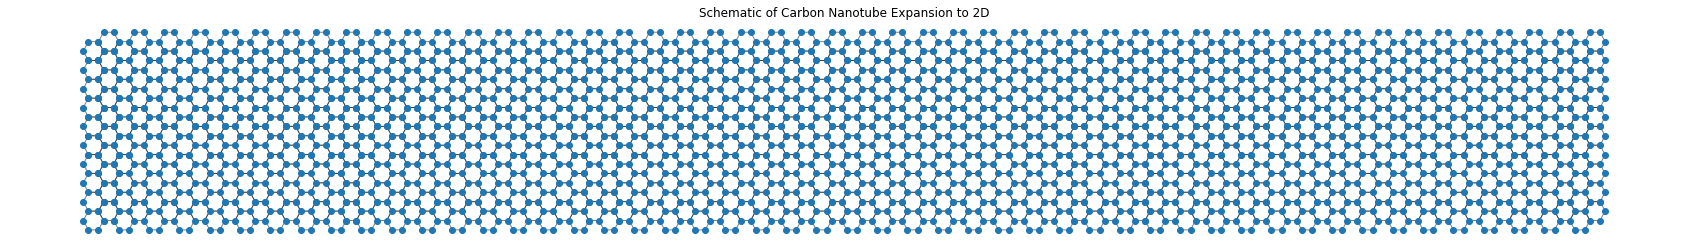

(14, 18, 0.7777777777777778)

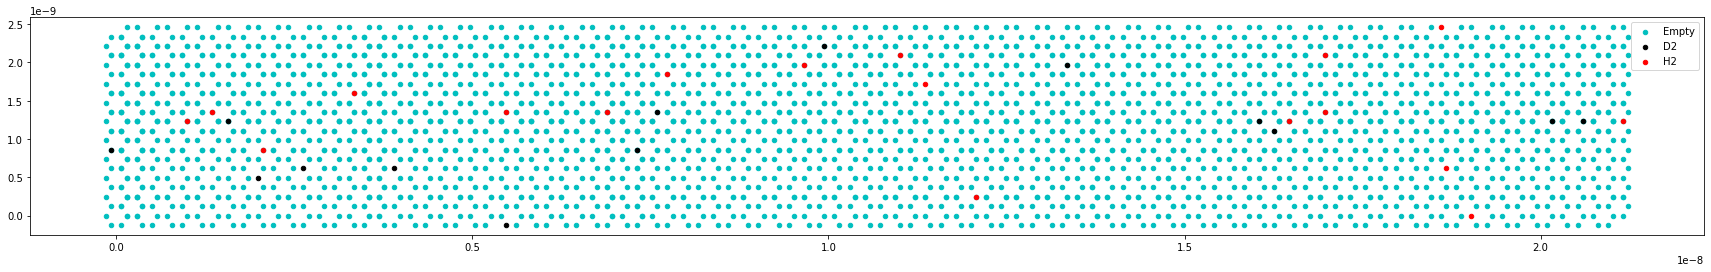

In [ ]:
####################  generate and plot the coordination #####################         
unitcell = hexagonal_unit_cell_generation()
newx, newy, cx, cy = hexagonal_lattice_generation(unitcell)#

newx, newy = np.round(newx,200), np.round(newy,200)
atom_position = np.concatenate((newy.reshape(-1,1), newx.reshape(-1,1)),axis=1)

atom_position = np.unique(atom_position,axis=0)

fig, ax = plt.subplots(1,figsize=(30,4))


ax.scatter(atom_position[:,0],atom_position[:,1],zorder=5)
for pos in range(len(cx)):
  x = cx[pos]
  y = cy[pos]
  
  hex = RegularPolygon((y, x),
                         numVertices = 6,
                         radius = lc,
                         orientation = np.radians(30),
                         facecolor = 'none',
                         alpha = 0.5,
                         edgecolor ='black')
  ax.add_patch(hex)
ax.axis('off')
ax.set_title('Schematic of Carbon Nanotube Expansion to 2D')
#ax.set_ylim(-1.5,20)
#ax.set_xlim(-1.5,150)
plt.show()

status=initialize()
plot_CNT(status)

# Run Code:

### try different Total Pressure and  partial pressure

In [ ]:
iteration = 15000
for P in np.arange(1,100,20):
  for x_D2 in np.arange(0.02,0.21,0.03):
    P = np.round(P,2)
    x_D2 = np.round(x_D2,3)
    status=initialize()
    mu_D2,mu_H2,z_D2,z_H2 = chemical_potential(P,x_D2)
    H2=[]#number of absorbed H2
    D2=[]#number of absorbed D2
    S=[]#selectiveity
    for _ in range(iteration):
        status=grand_canonical(status)   
        d2,h2,s=count_sites(status)[3:6]
        H2.append(h2)
        D2.append(d2)
        #S.append(s)
    np.save('H2_P{}_X{}'.format(str(P),str(x_D2)),H2)
    np.save('D2_P{}_X{}'.format(str(P),str(x_D2)),D2)
    print('Finish: P{}_X{}'.format(str(P),str(x_D2)))

Finish: P1_X0.02
Finish: P1_X0.05
Finish: P1_X0.08
Finish: P1_X0.11
Finish: P1_X0.14
Finish: P1_X0.17
Finish: P1_X0.2
Finish: P21_X0.02
Finish: P21_X0.05
Finish: P21_X0.08
Finish: P21_X0.11
Finish: P21_X0.14
Finish: P21_X0.17
Finish: P21_X0.2
Finish: P41_X0.02
Finish: P41_X0.05
Finish: P41_X0.08
Finish: P41_X0.11
Finish: P41_X0.14
Finish: P41_X0.17
Finish: P41_X0.2
Finish: P61_X0.02
Finish: P61_X0.05
Finish: P61_X0.08
Finish: P61_X0.11
Finish: P61_X0.14
Finish: P61_X0.17
Finish: P61_X0.2
Finish: P81_X0.02
Finish: P81_X0.05
Finish: P81_X0.08
Finish: P81_X0.11
Finish: P81_X0.14
Finish: P81_X0.17
Finish: P81_X0.2


In [ ]:
!zip -r SelectivityData2.zip SelectivityData/

  adding: SelectivityData/ (stored 0%)
  adding: SelectivityData/D2_P901_X0.14.npy (deflated 92%)
  adding: SelectivityData/H2_P61_X0.11.npy (deflated 94%)
  adding: SelectivityData/D2_P401_X0.14.npy (deflated 92%)
  adding: SelectivityData/H2_P401_X0.2.npy (deflated 94%)
  adding: SelectivityData/D2_P101_X0.14.npy (deflated 91%)
  adding: SelectivityData/D2_P61_X0.05.npy (deflated 91%)
  adding: SelectivityData/D2_P41_X0.08.npy (deflated 91%)
  adding: SelectivityData/H2_P401_X0.17.npy (deflated 94%)
  adding: SelectivityData/H2_P81_X0.14.npy (deflated 94%)
  adding: SelectivityData/D2_P1_X0.17.npy (deflated 91%)
  adding: SelectivityData/D2_P101_X0.08.npy (deflated 92%)
  adding: SelectivityData/H2_P21_X0.08.npy (deflated 94%)
  adding: SelectivityData/H2_P301_X0.2.npy (deflated 94%)
  adding: SelectivityData/D2_P701_X0.08.npy (deflated 92%)
  adding: SelectivityData/H2_P81_X0.2.npy (deflated 94%)
  adding: SelectivityData/H2_P201_X0.17.npy (deflated 94%)
  adding: SelectivityData/D2

### New Section

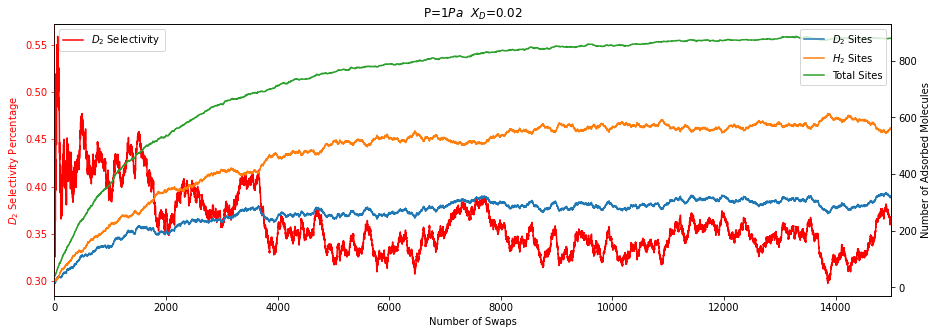

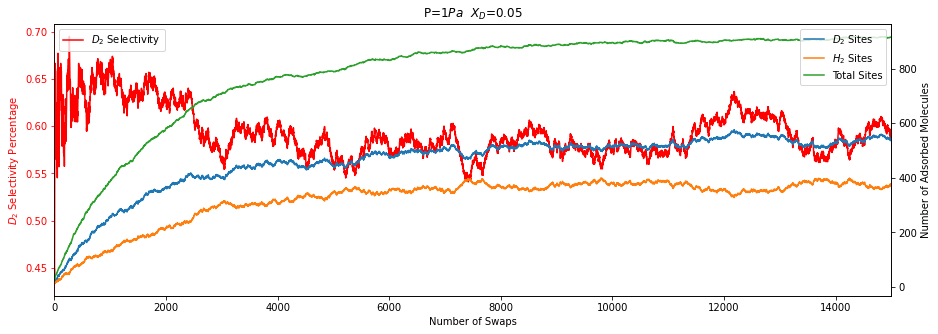

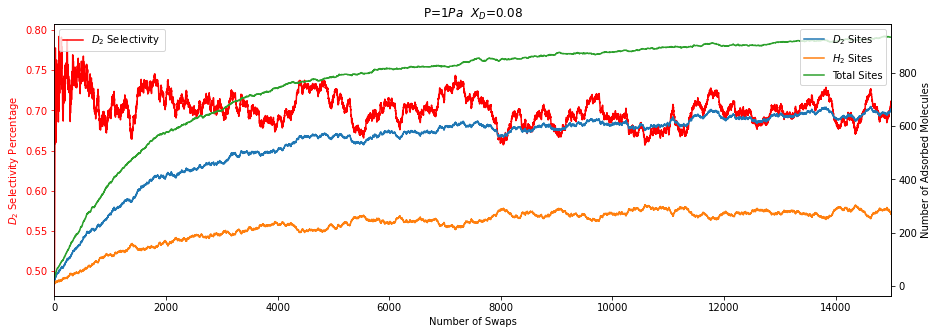

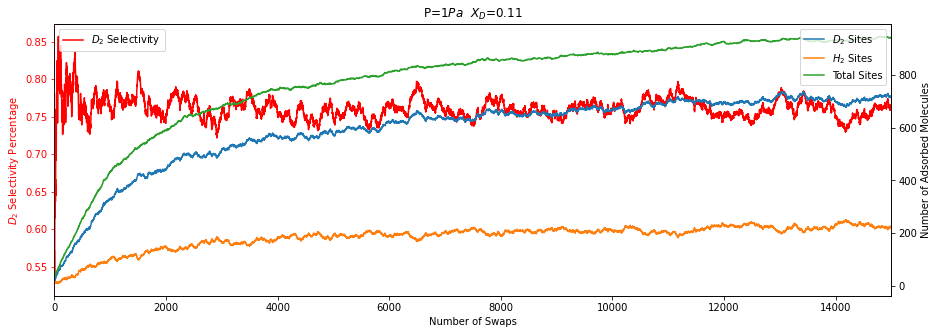

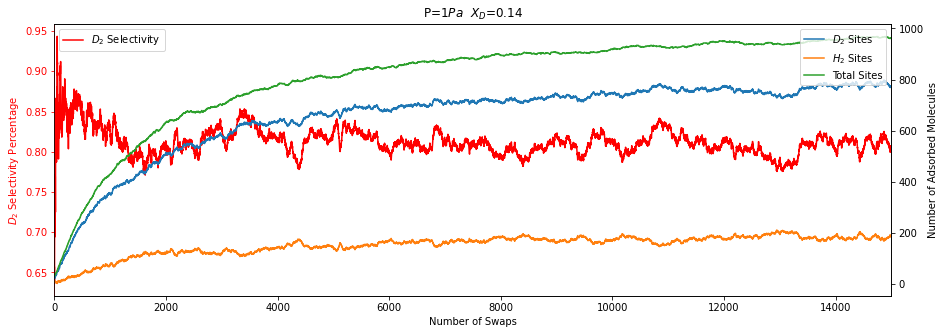

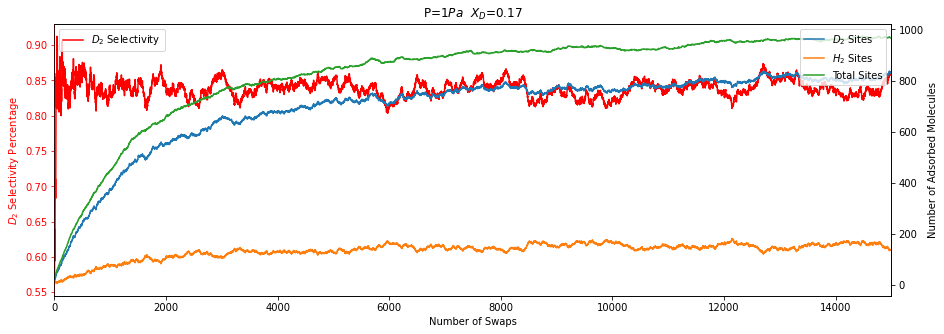

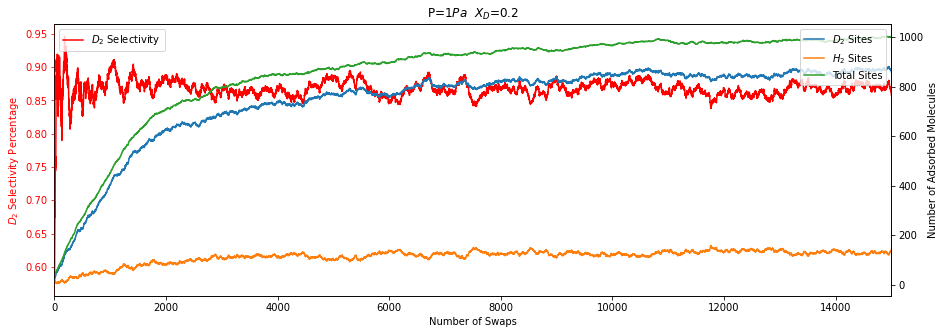

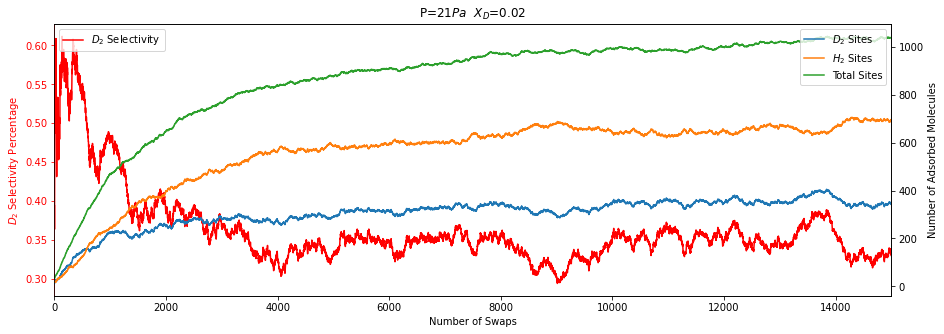

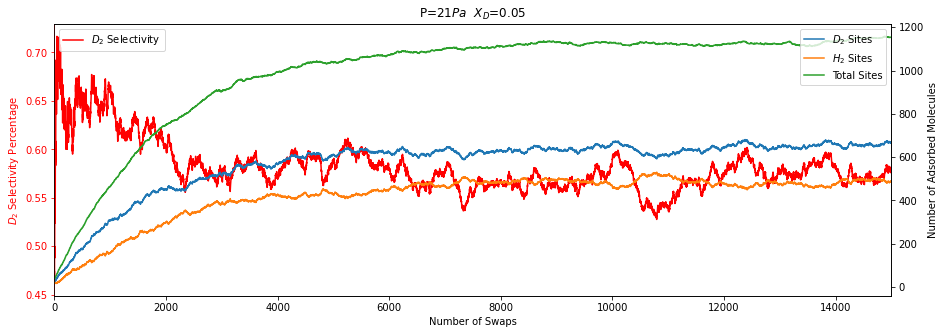

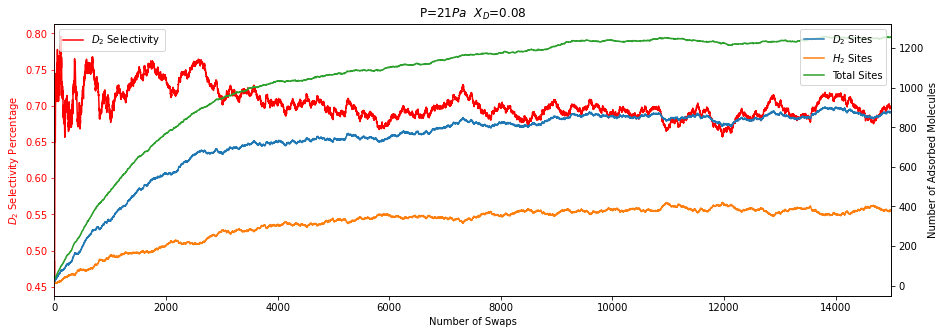

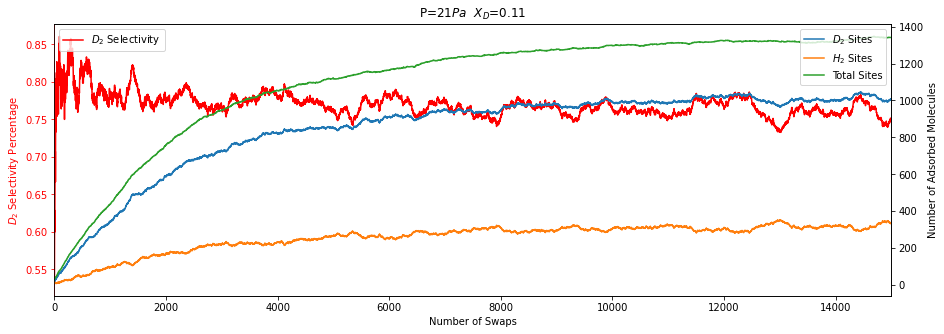

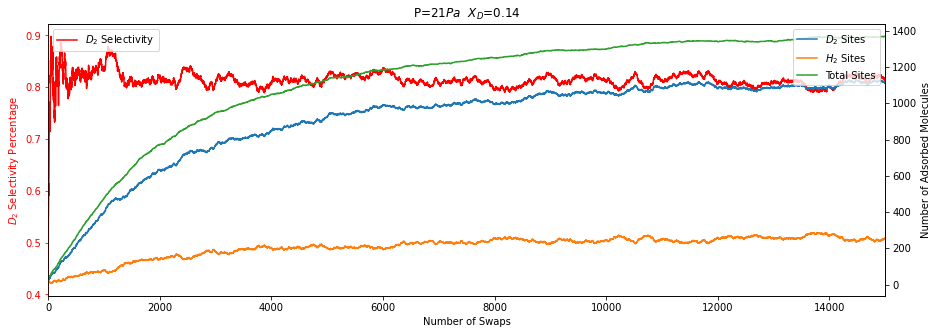

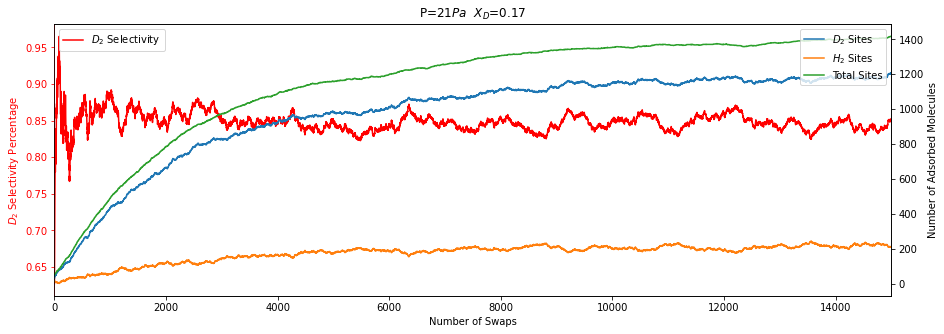

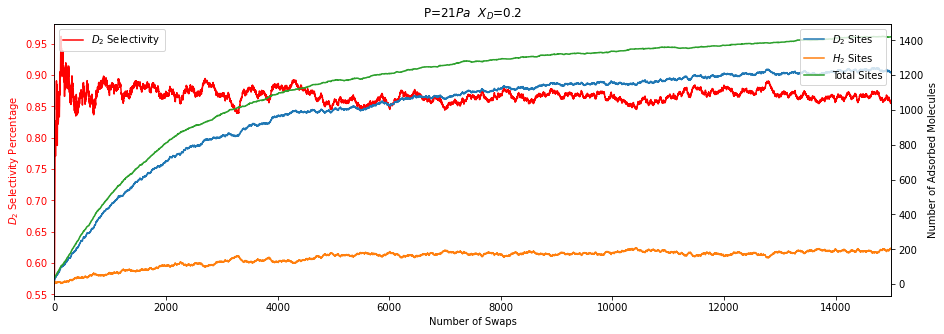

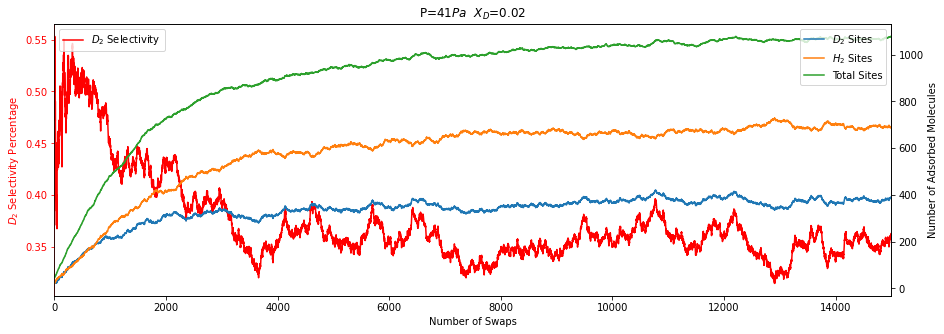

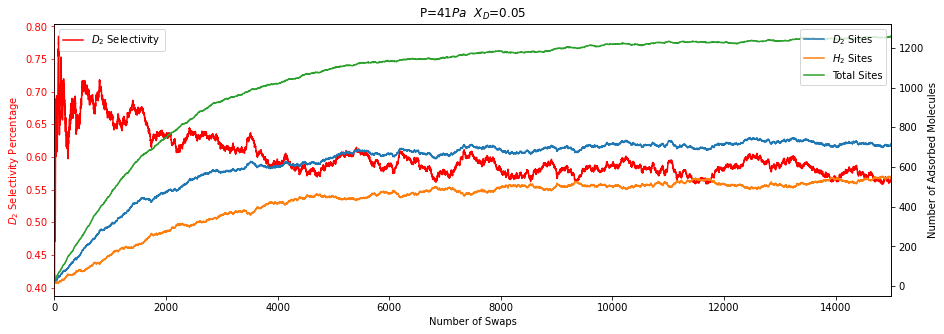

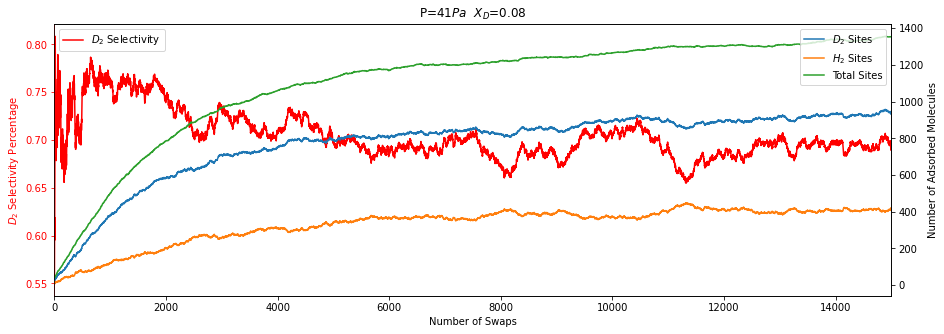

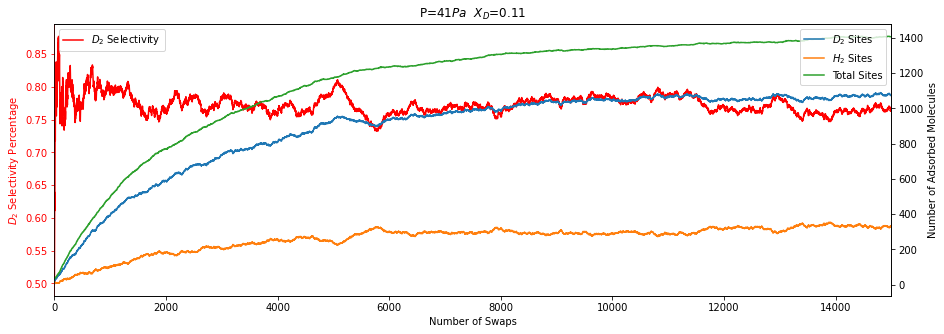

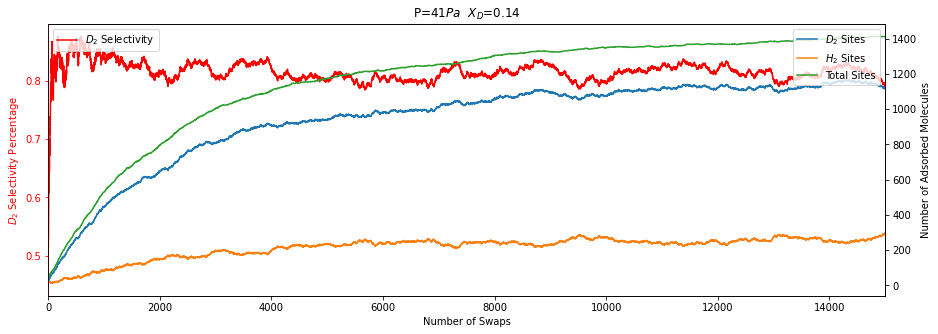

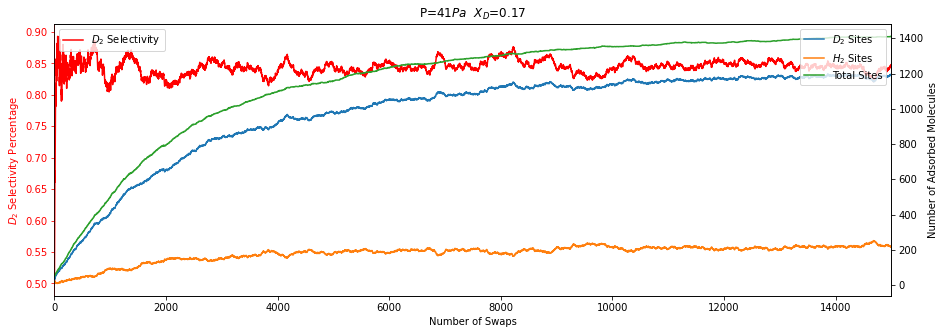

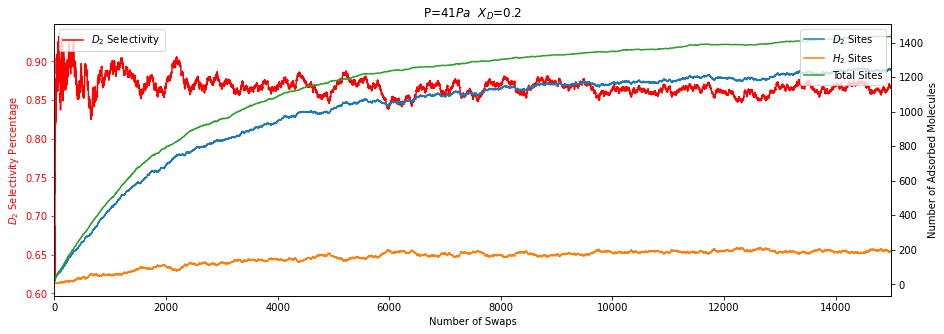

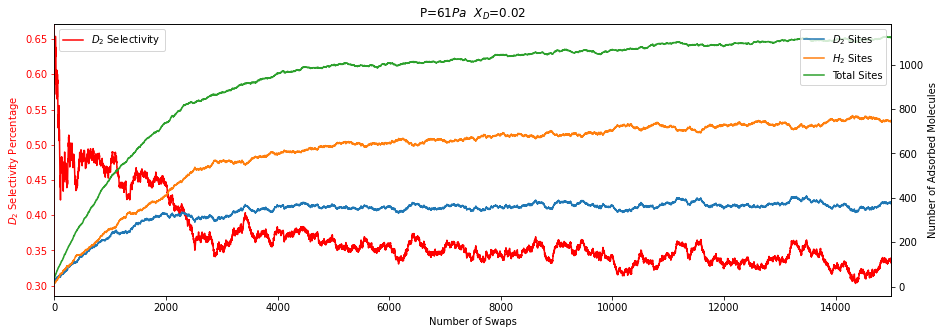

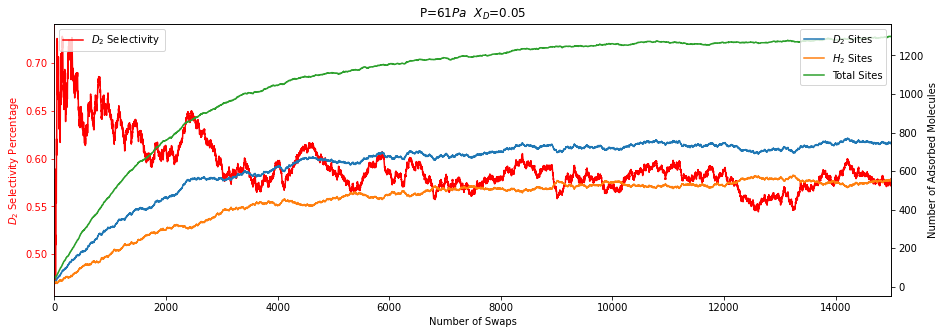

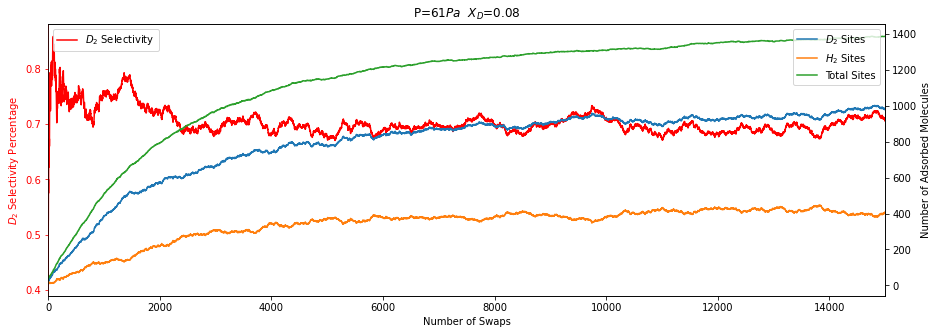

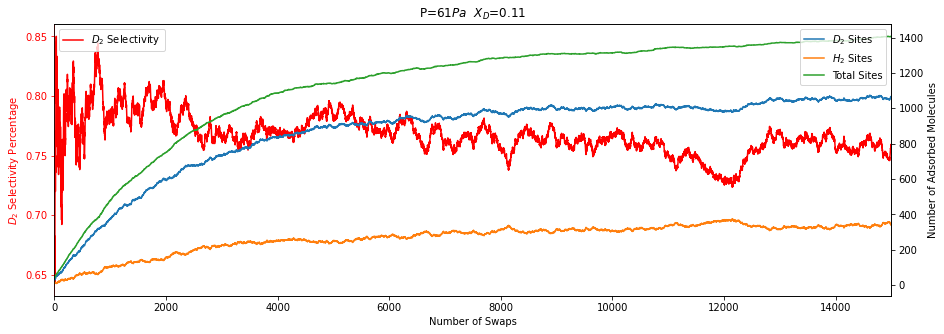

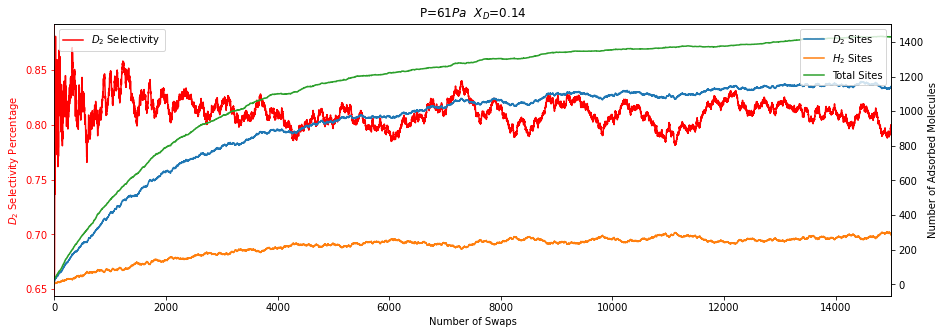

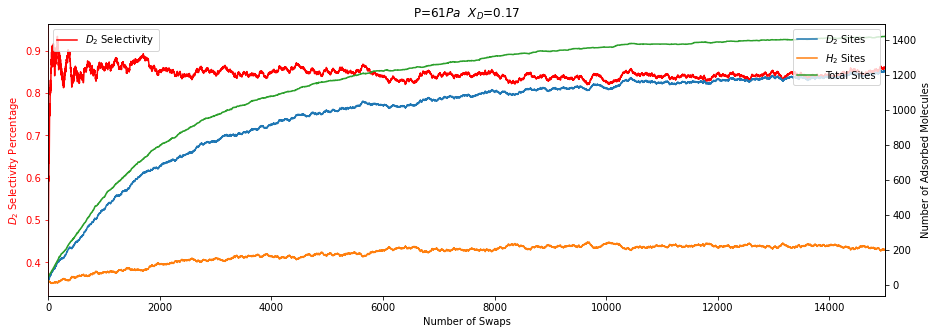

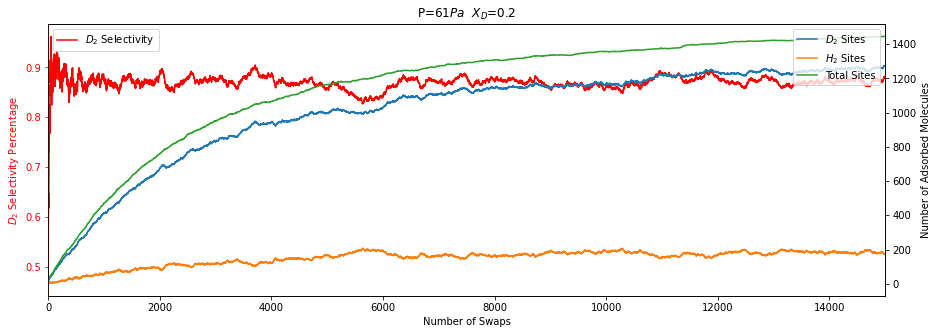

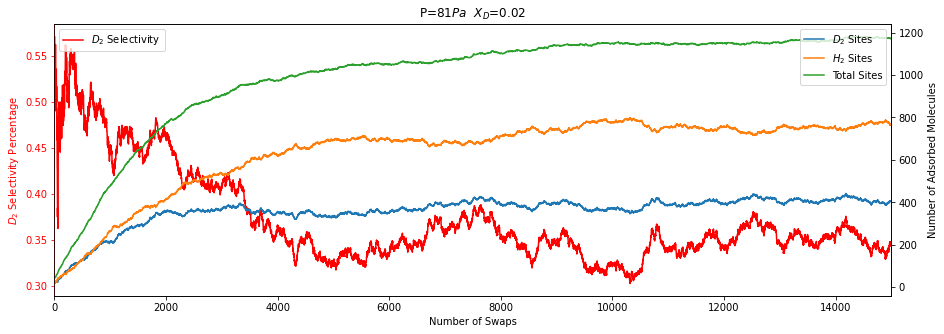

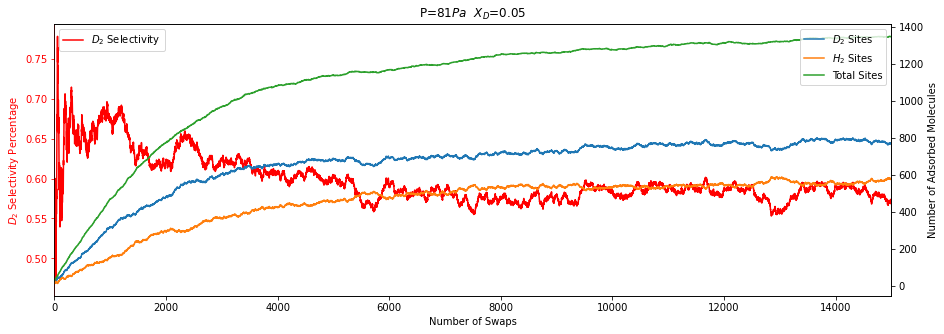

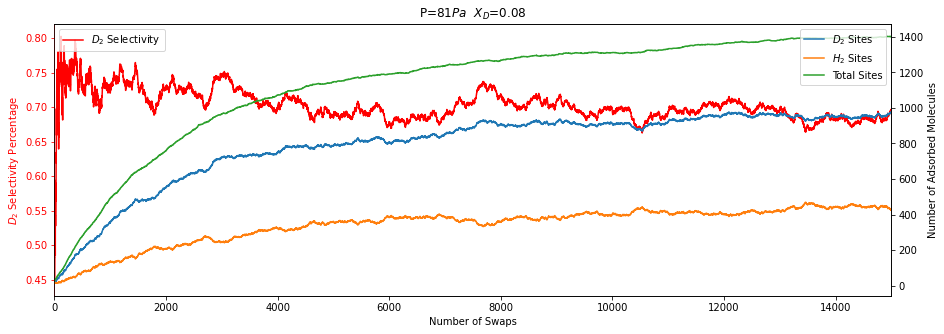

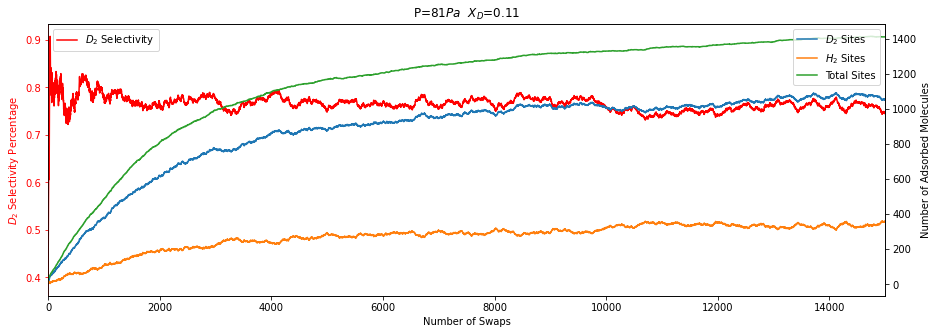

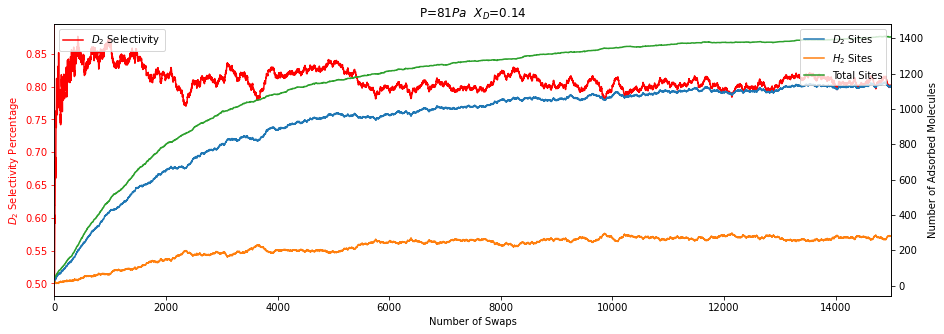

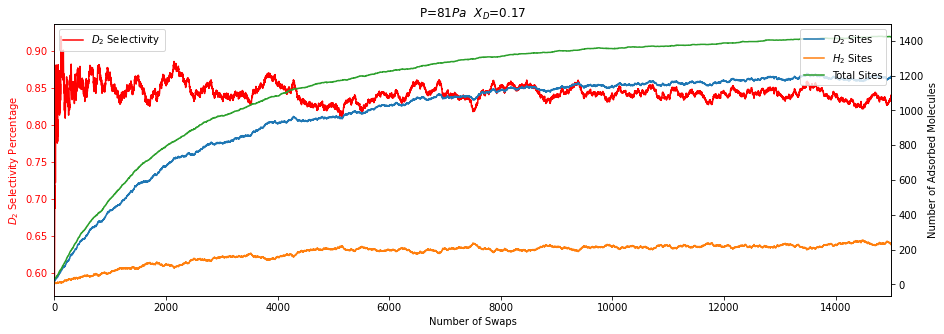

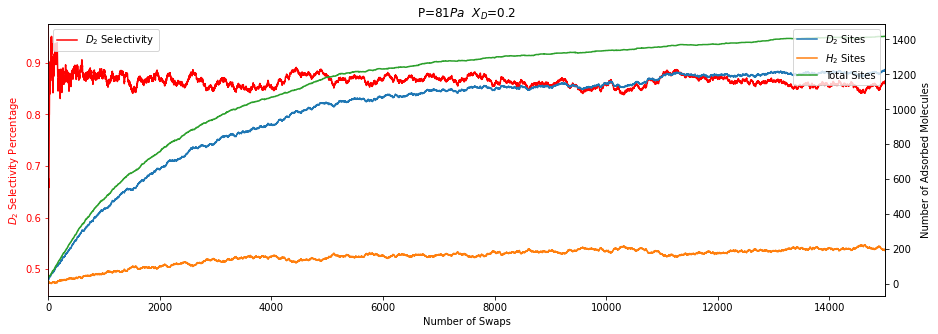

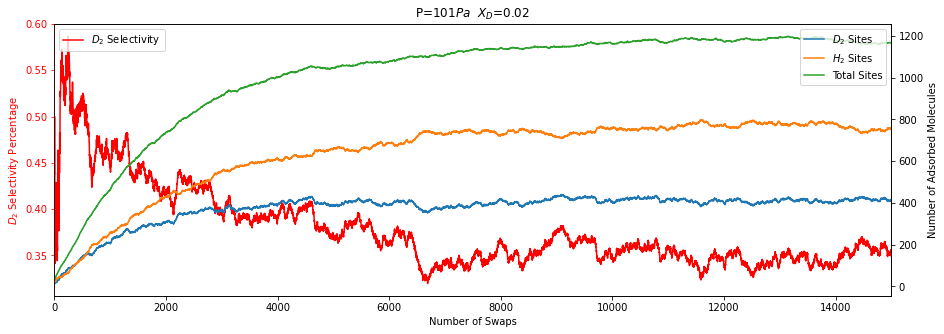

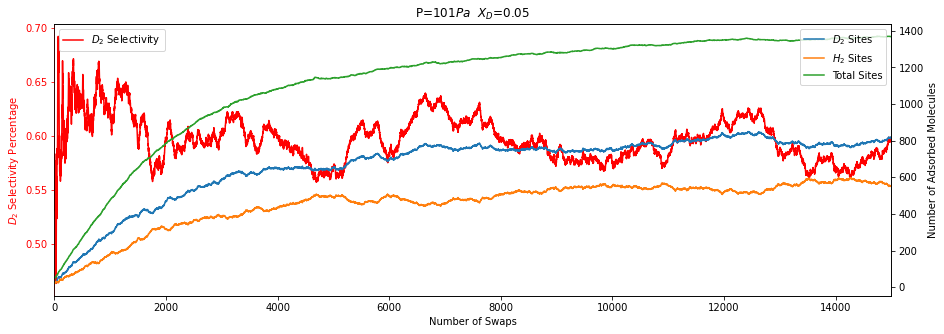

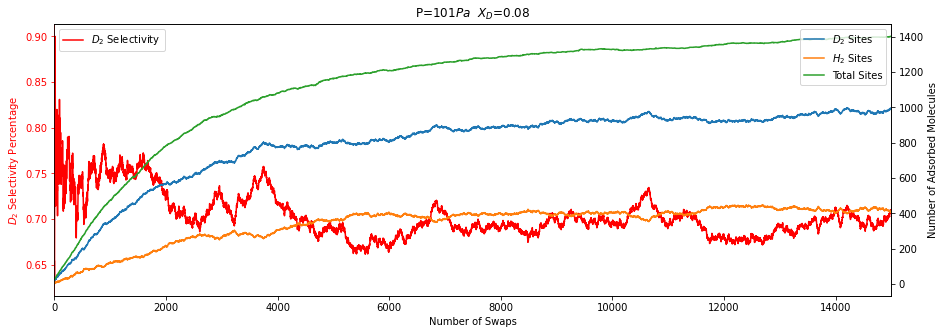

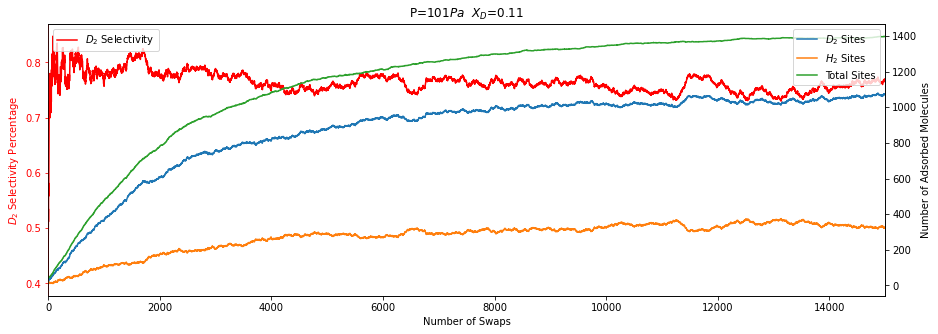

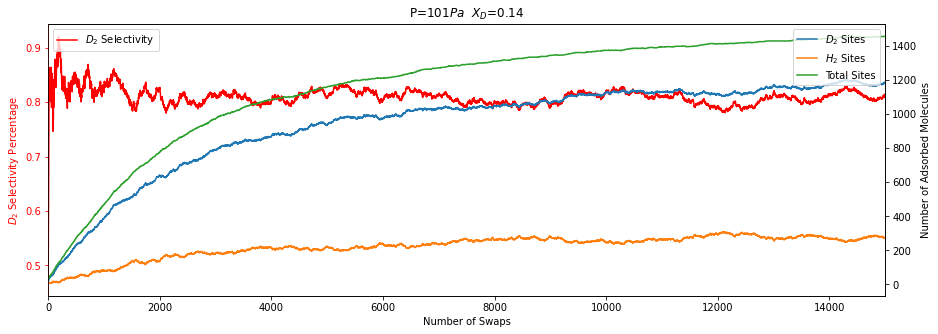

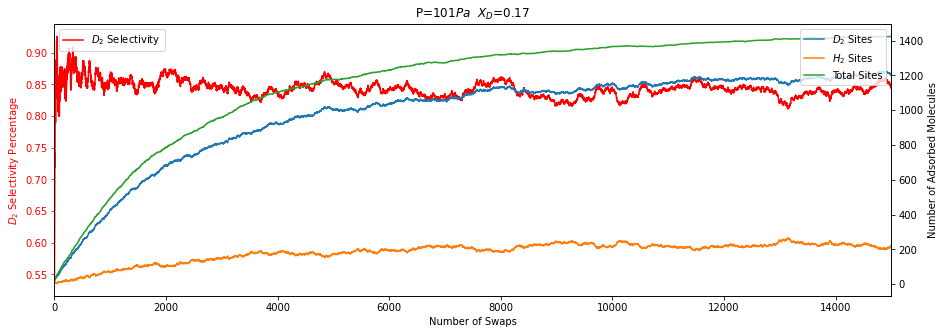

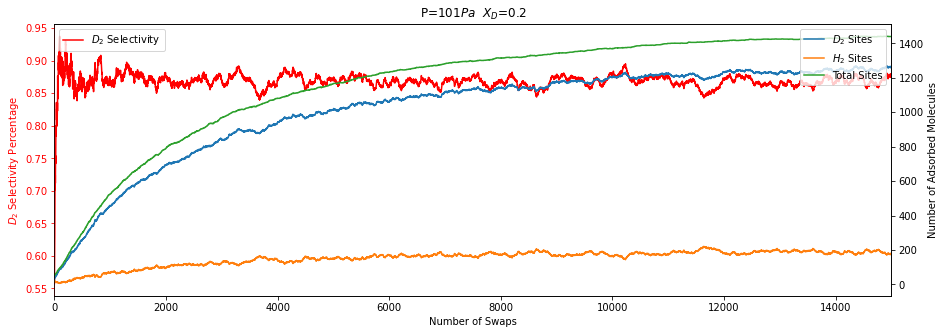

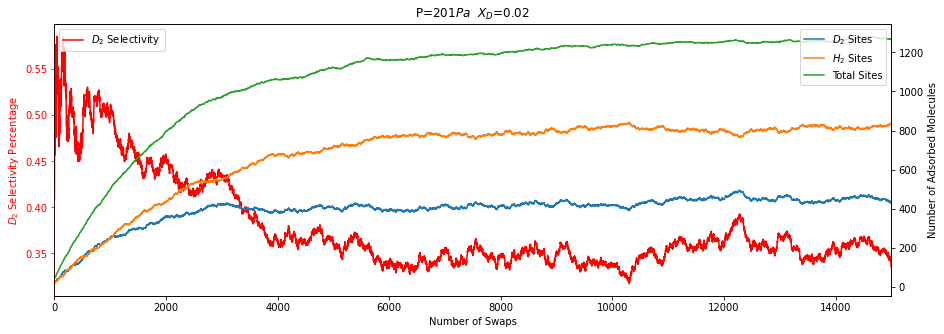

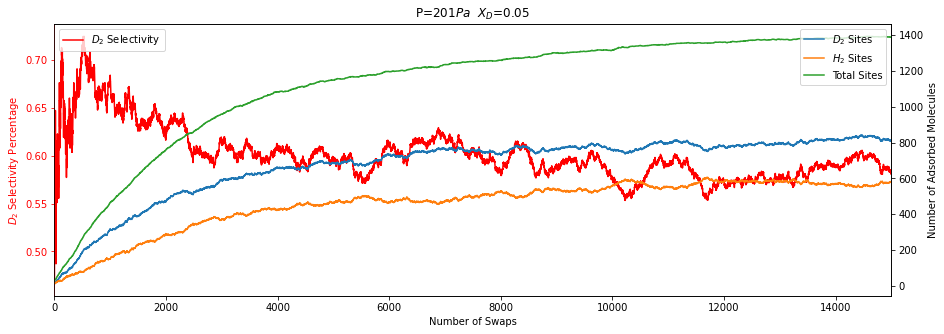

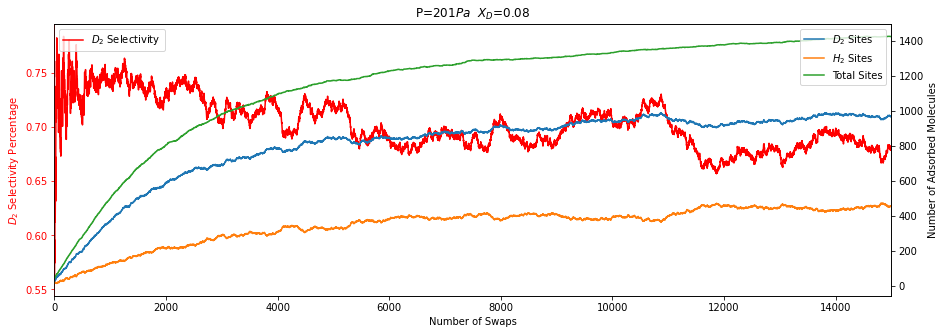

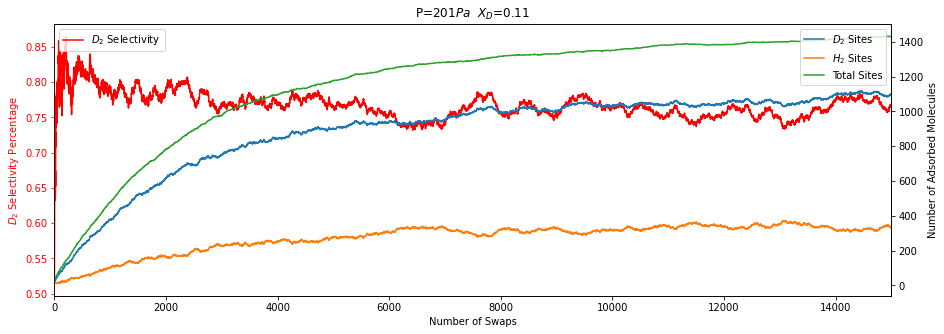

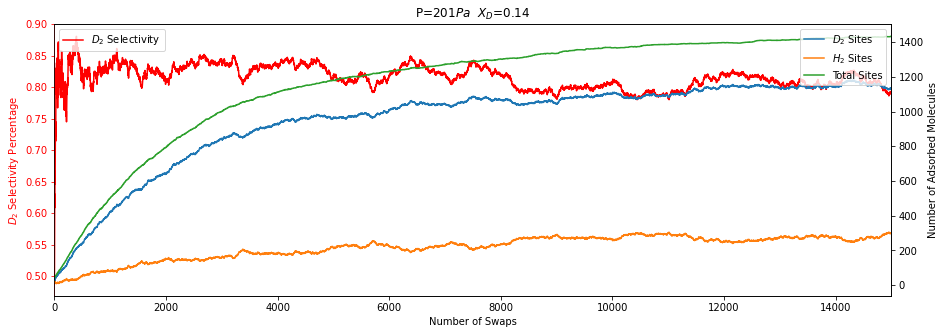

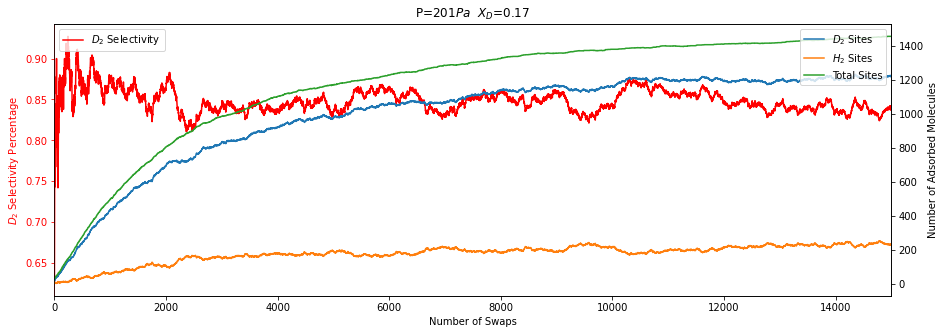

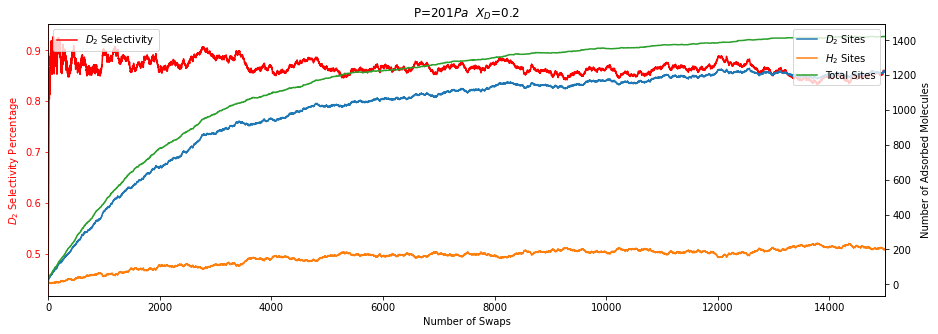

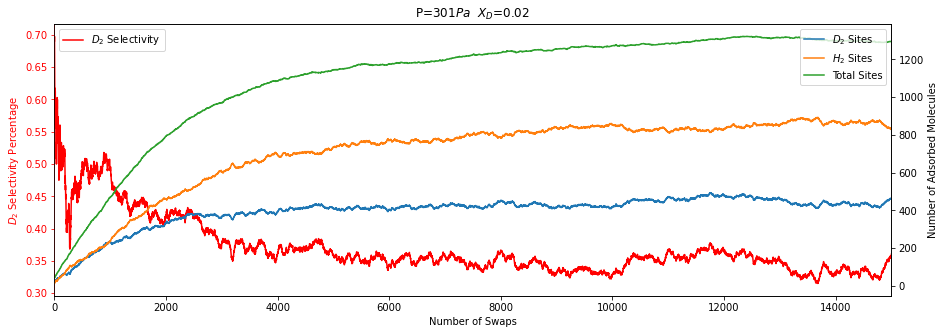

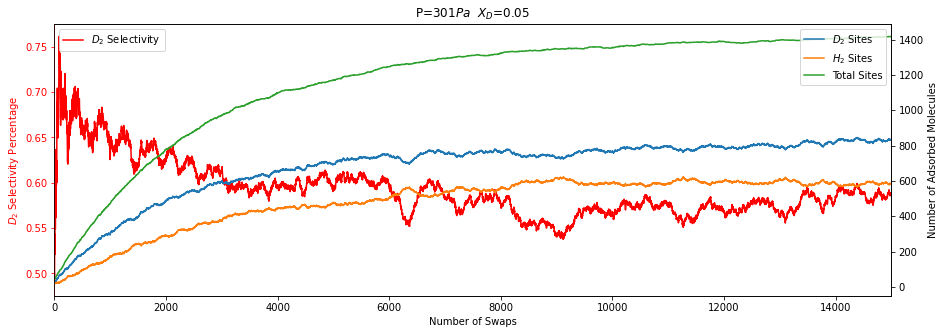

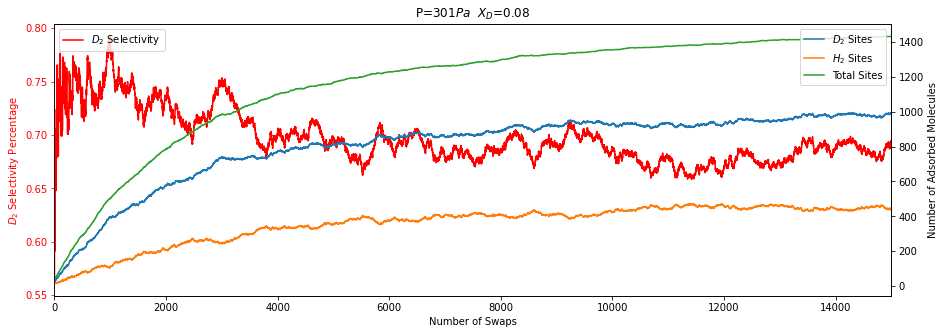

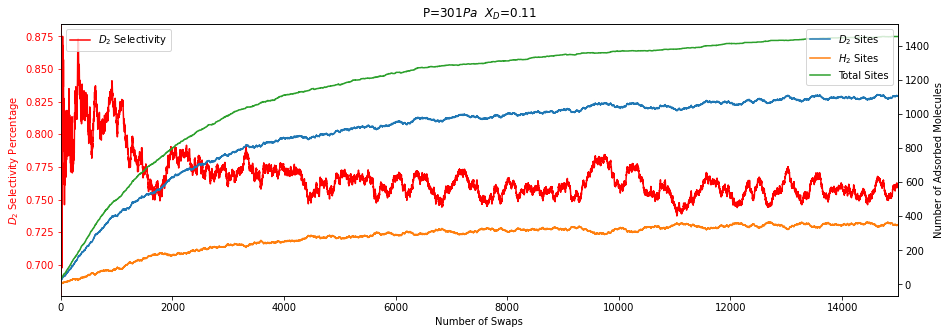

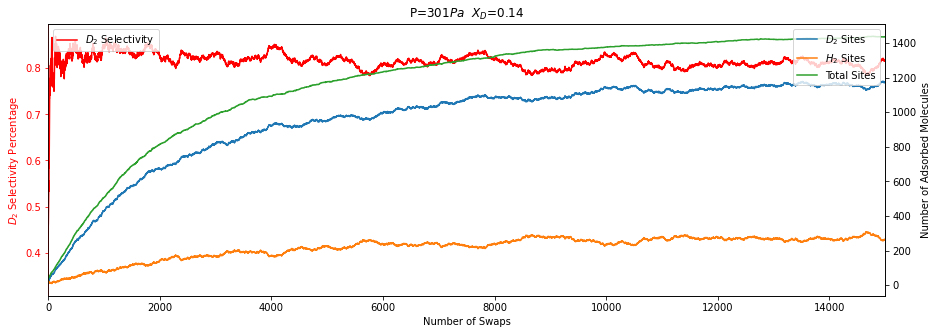

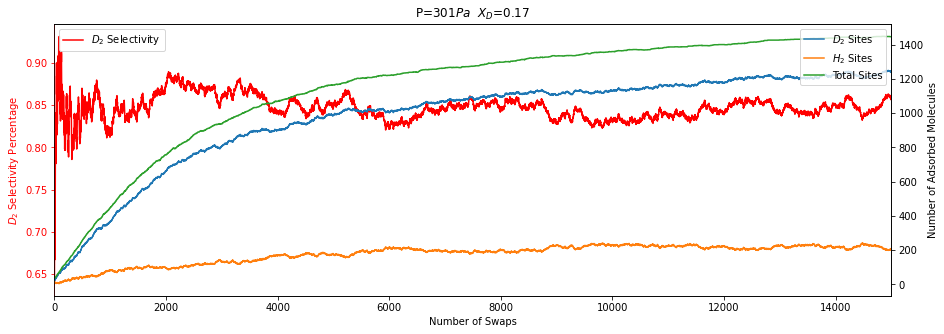

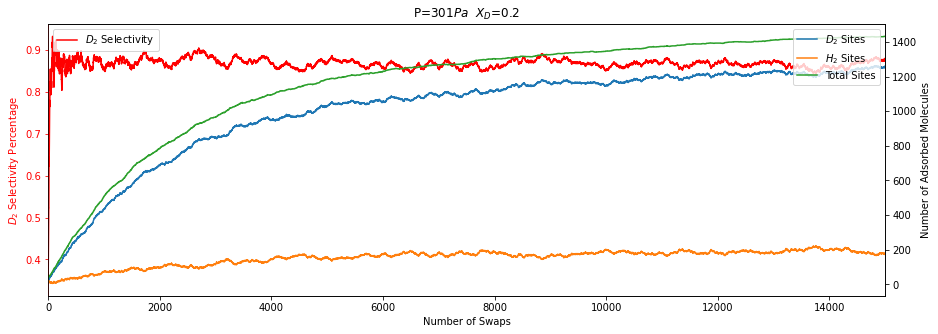

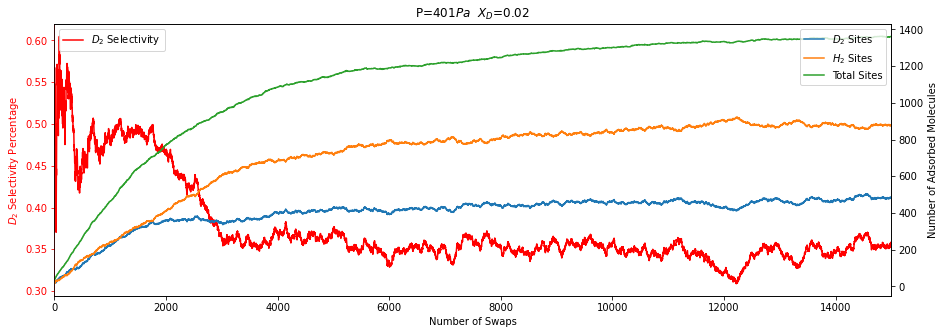

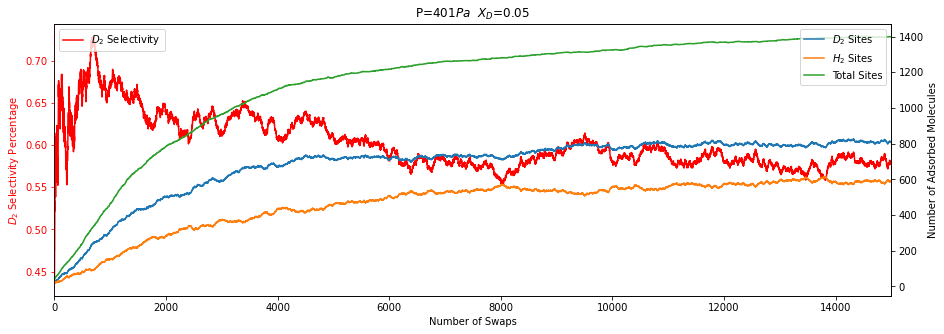

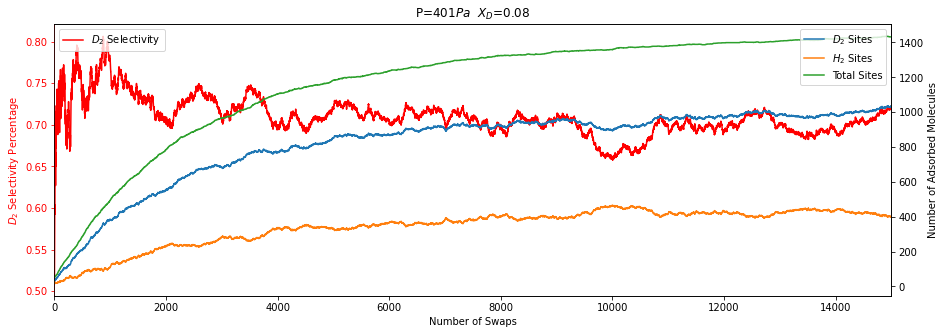

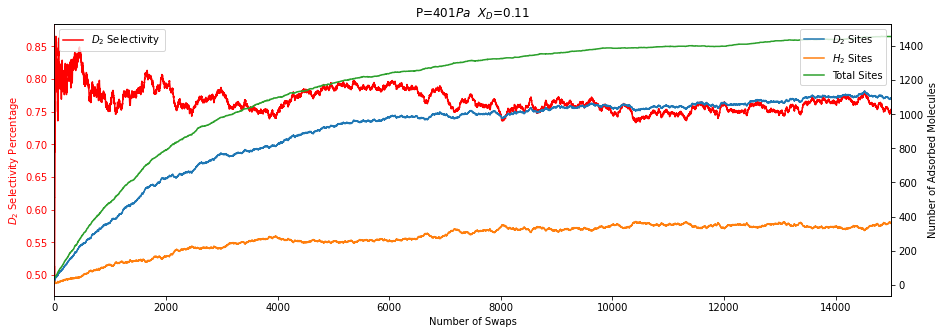

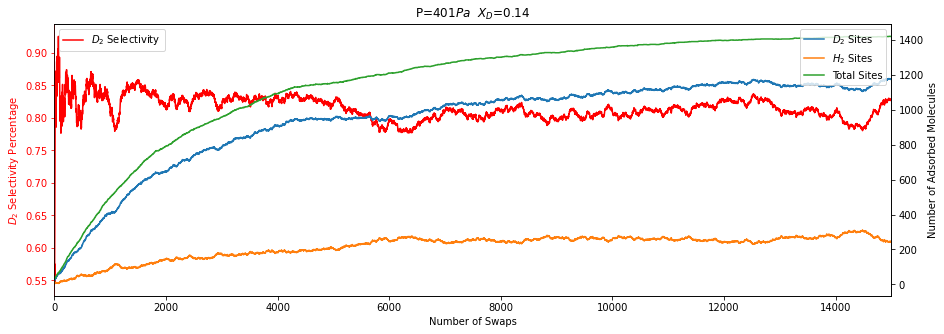

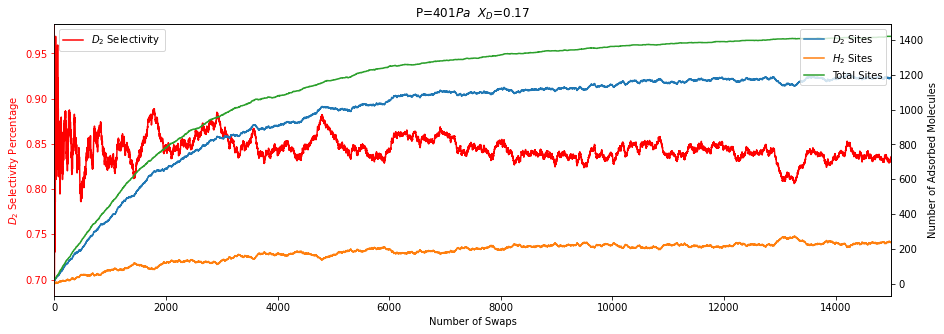

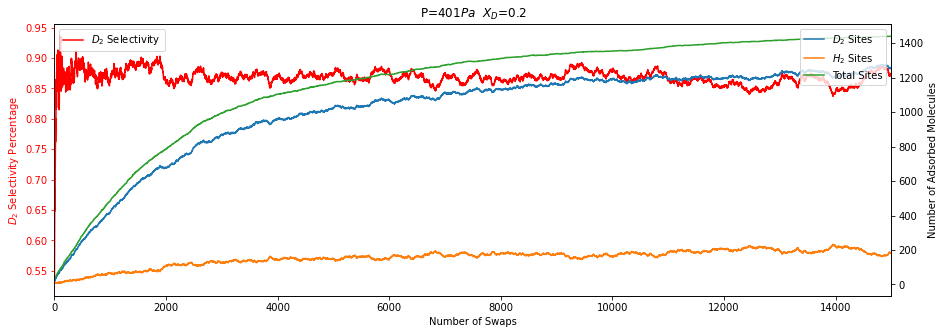

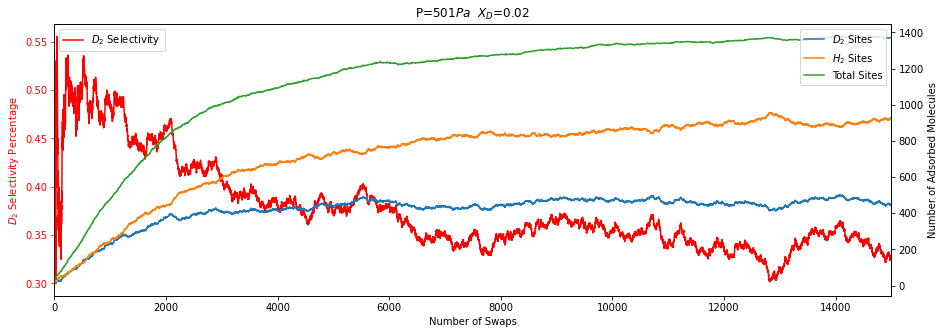

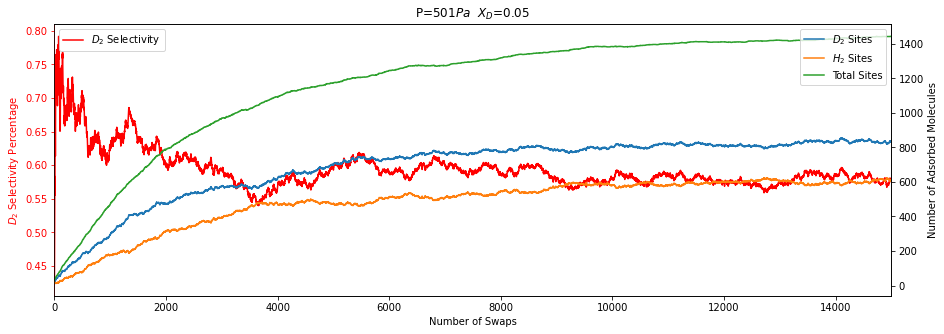

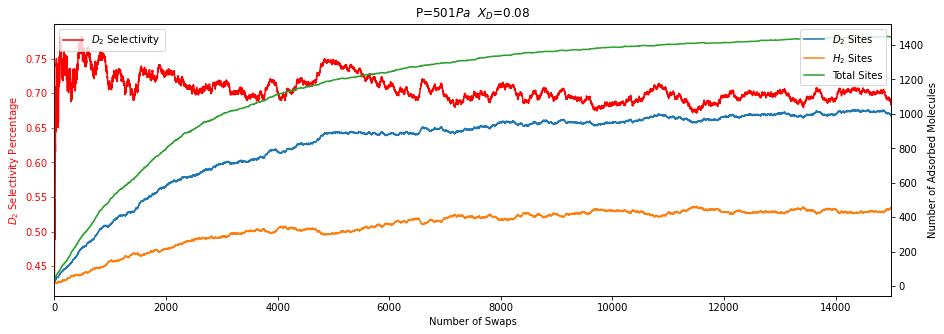

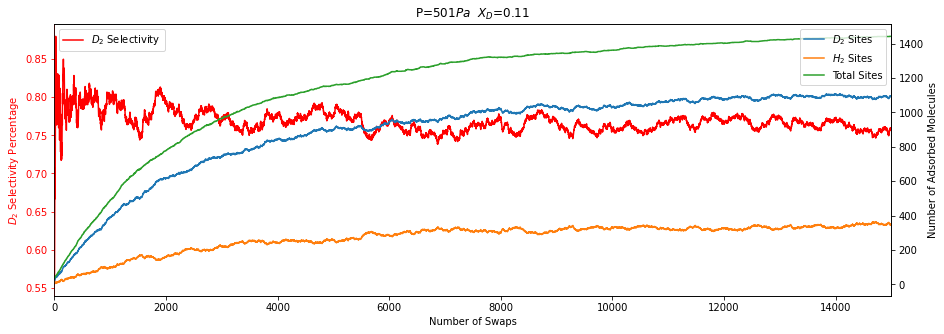

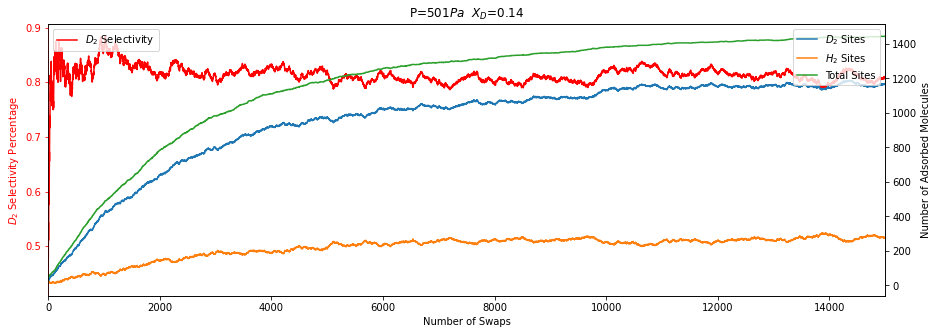

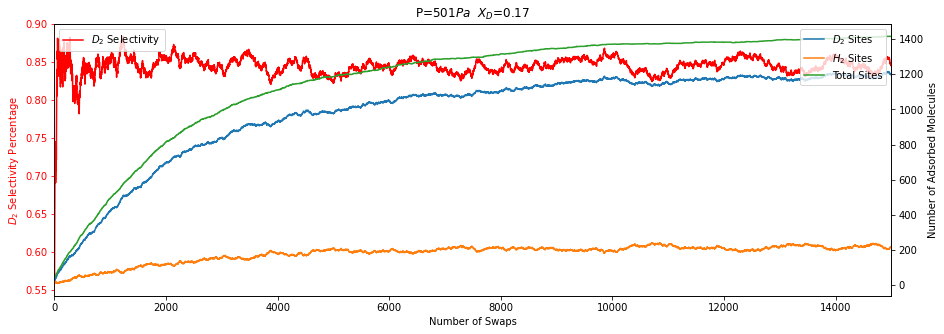

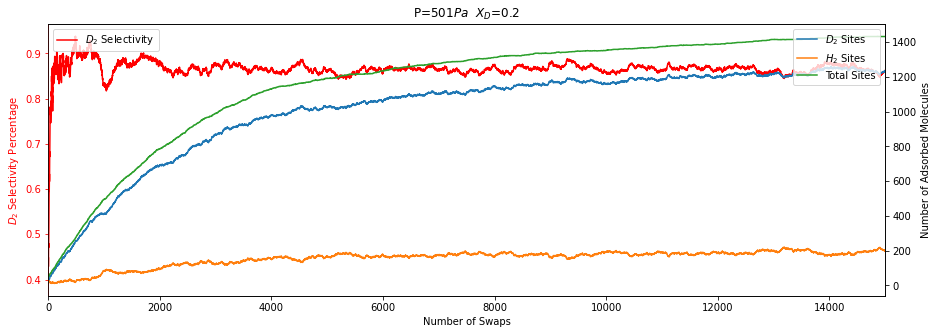

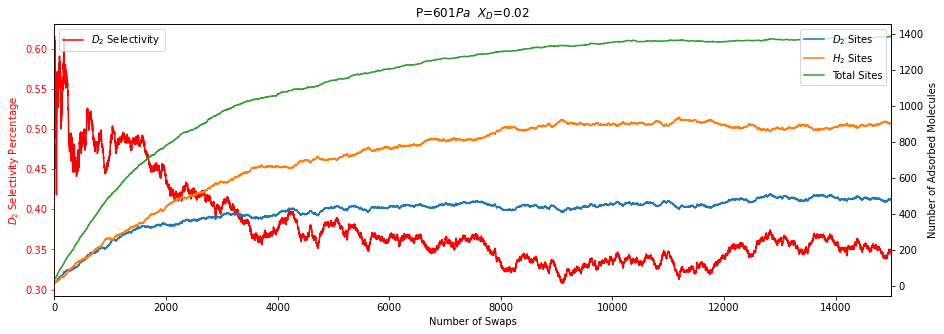

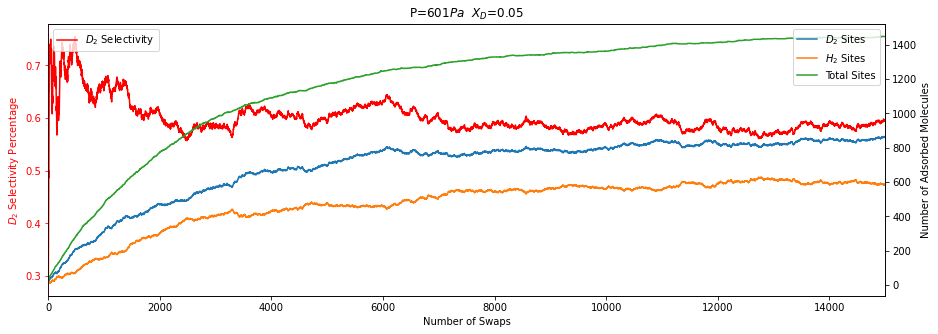

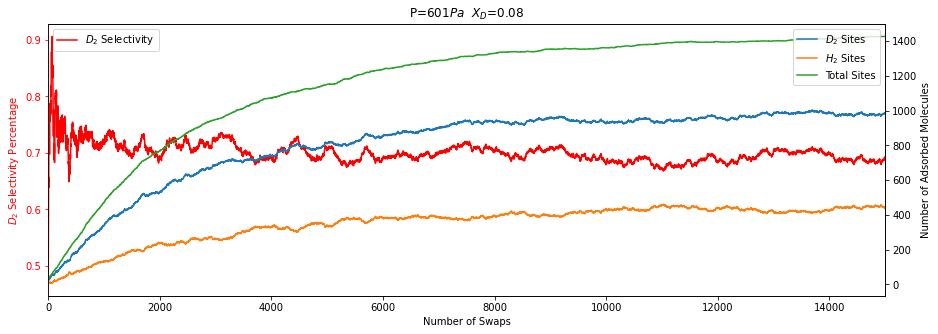

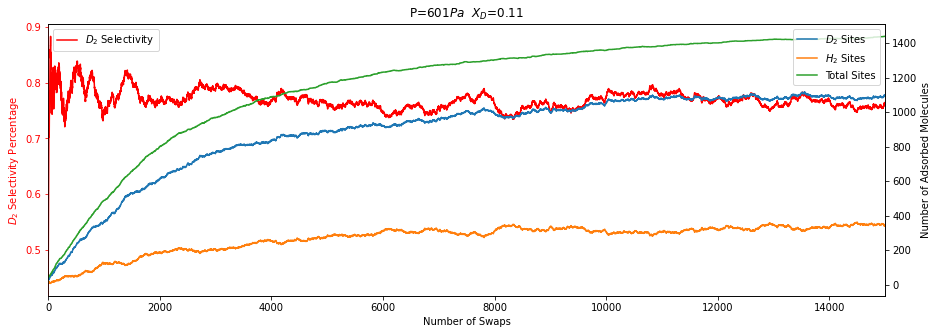

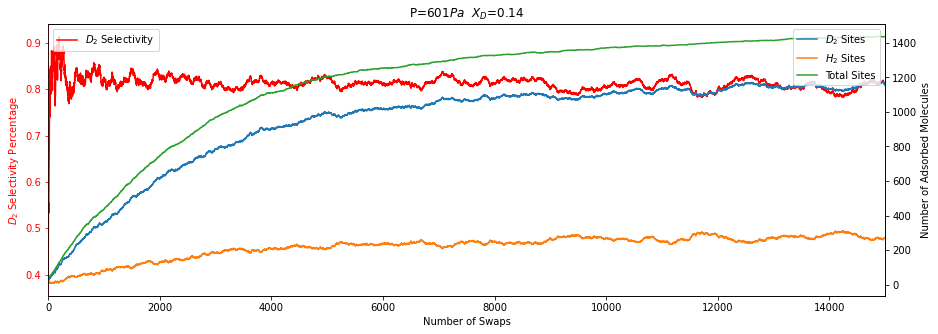

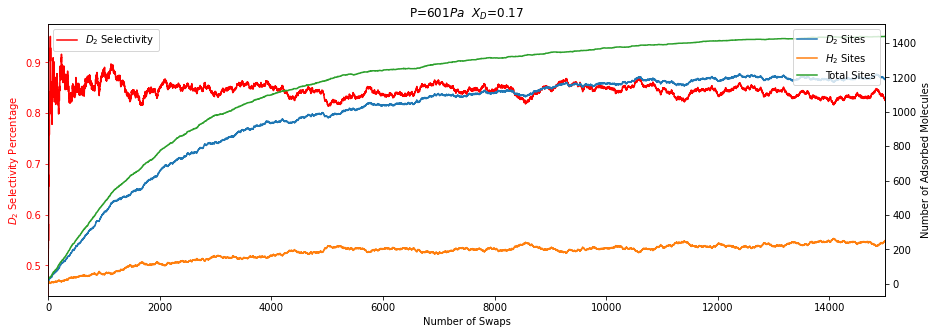

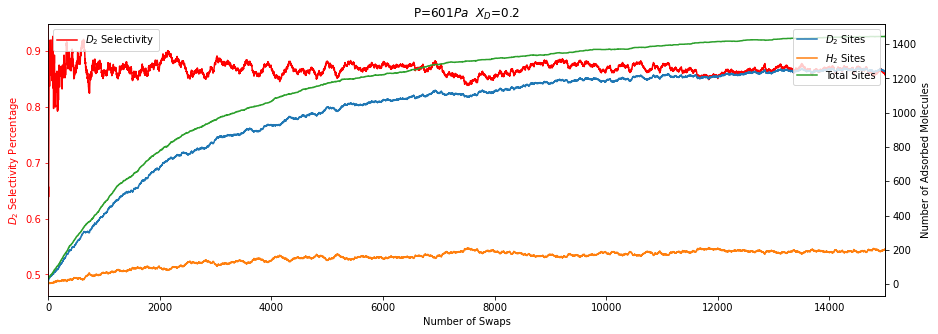

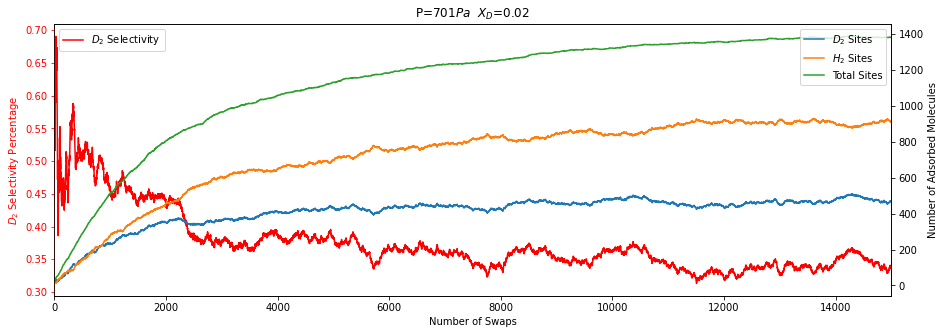

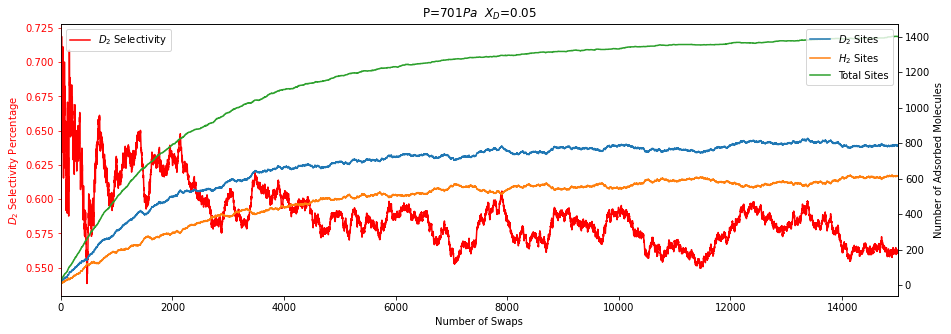

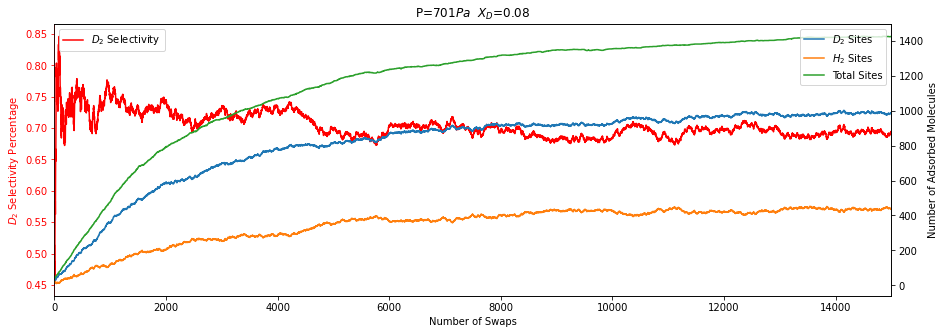

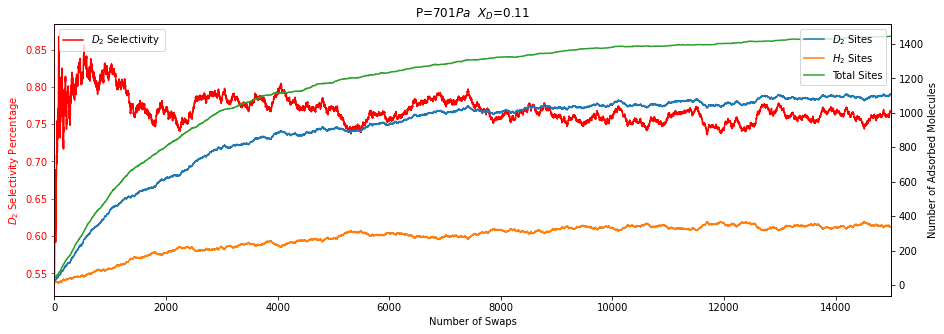

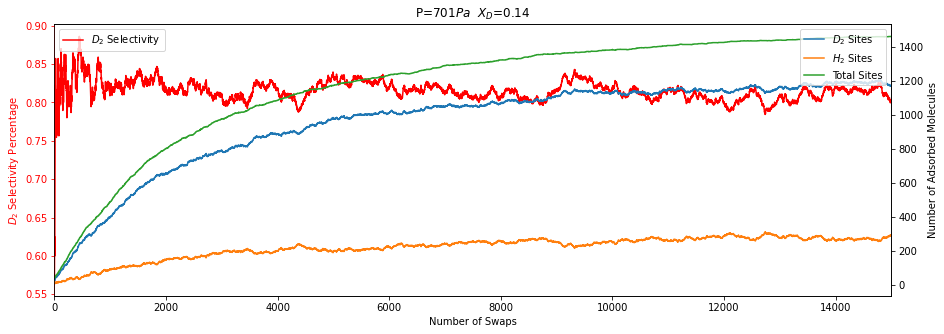

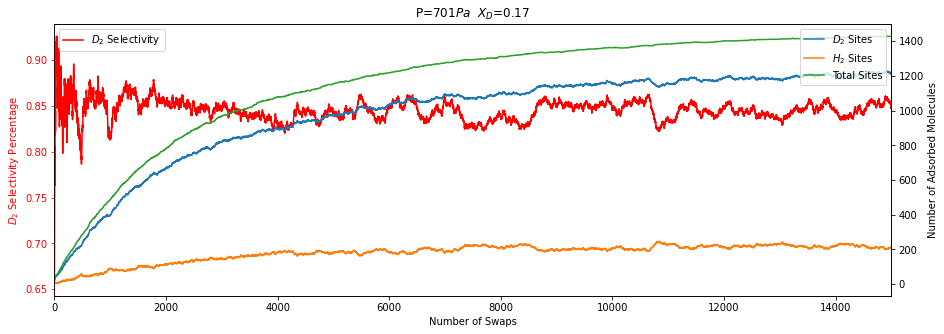

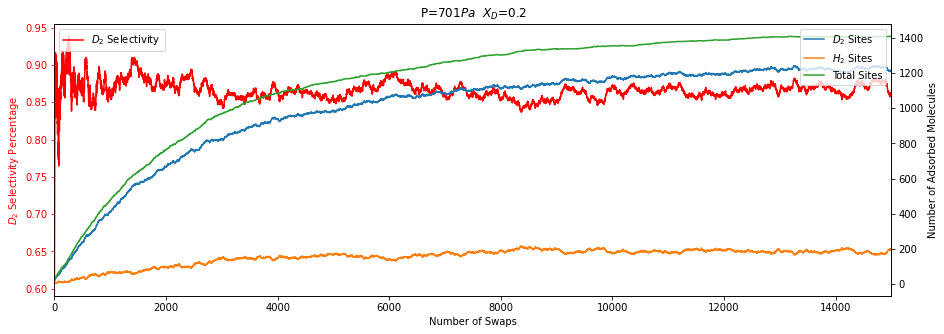

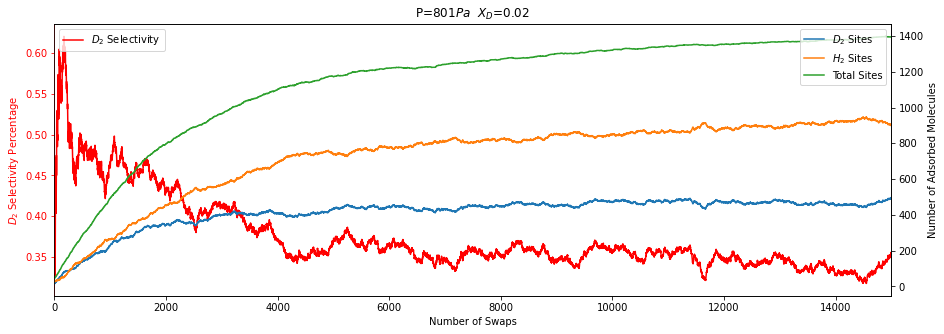

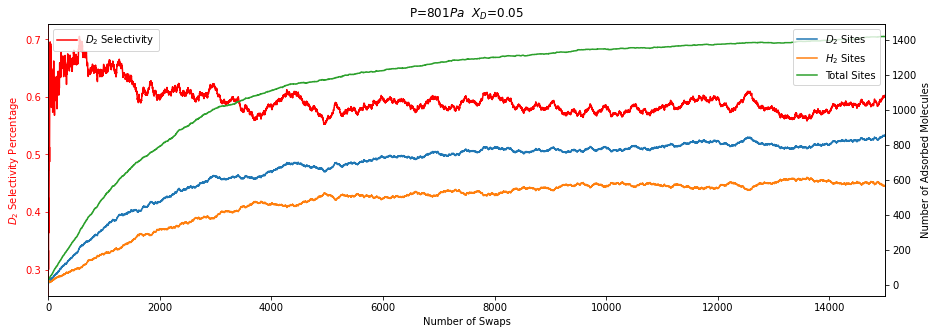

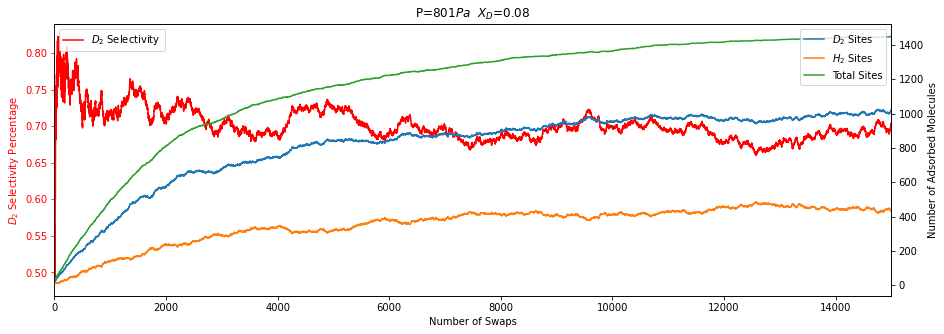

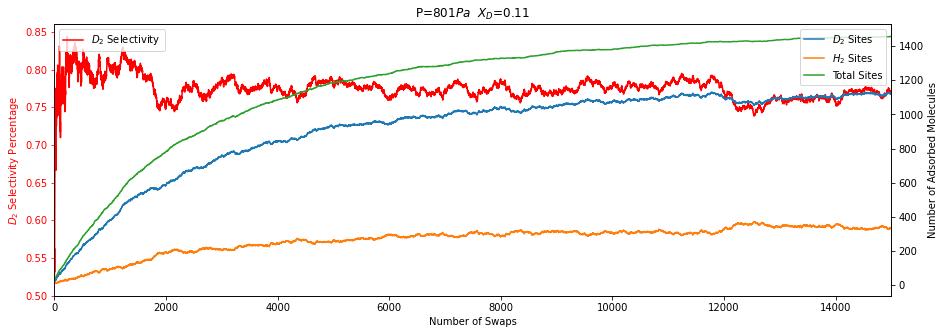

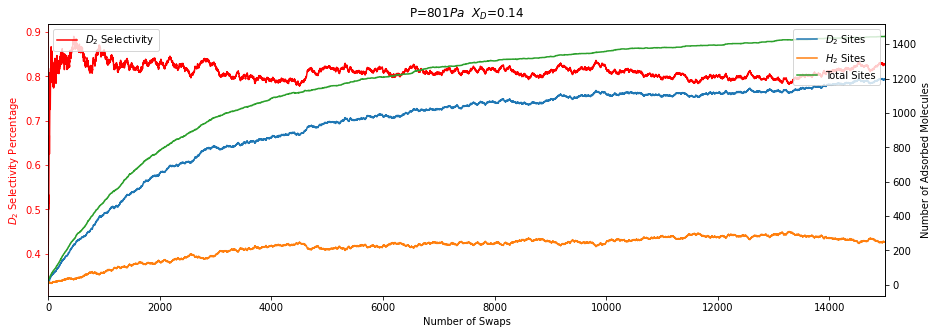

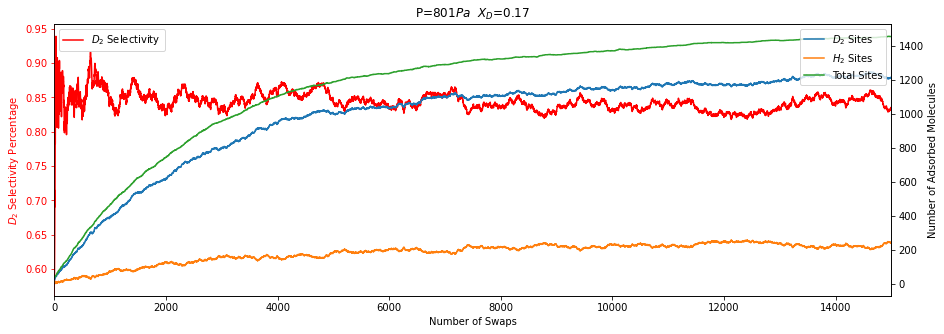

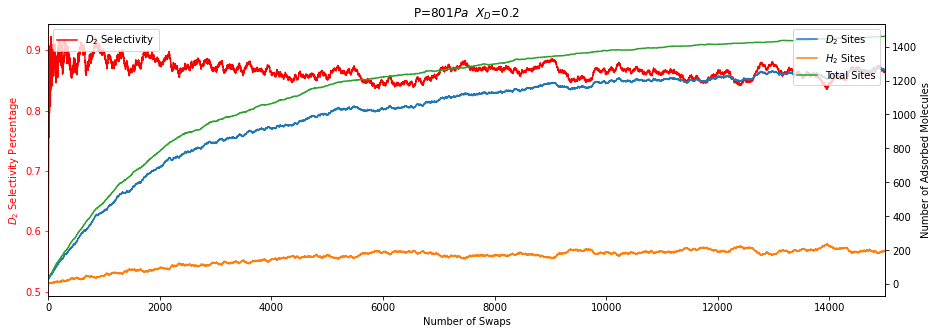

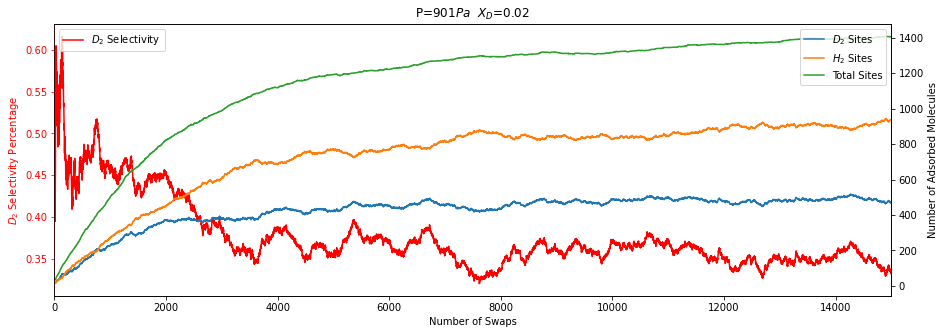

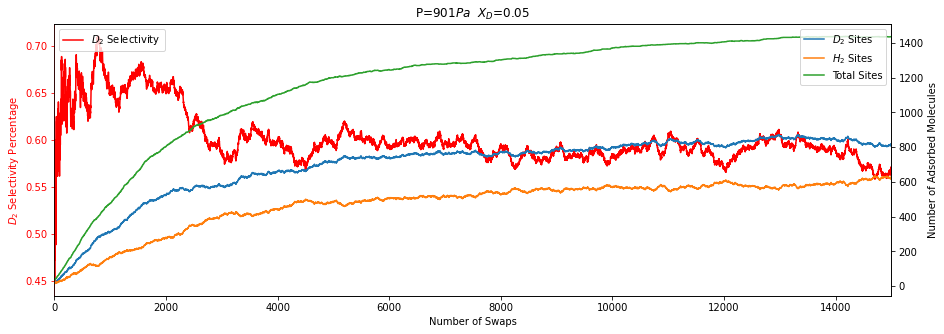

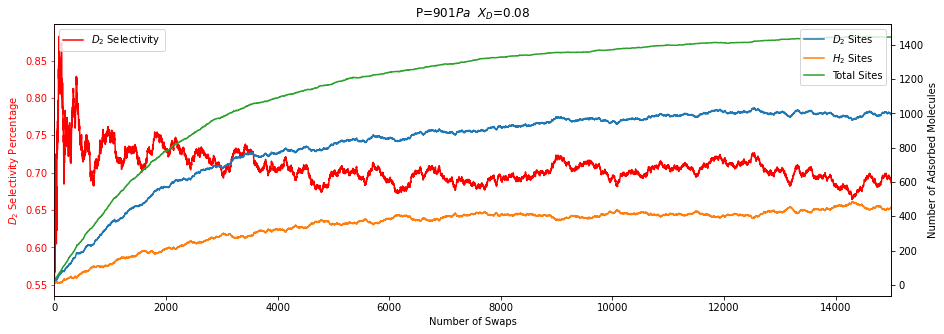

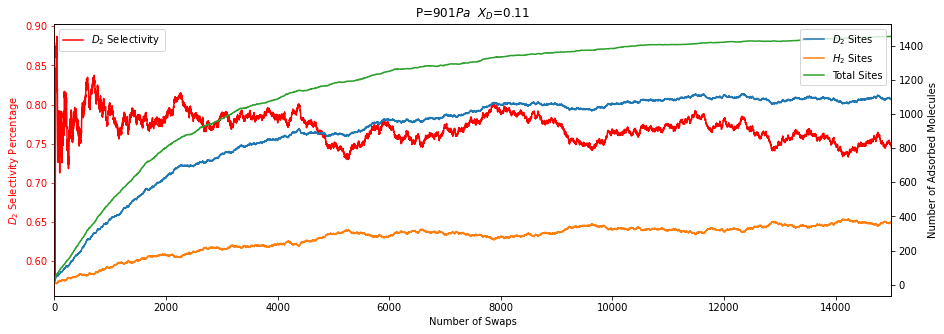

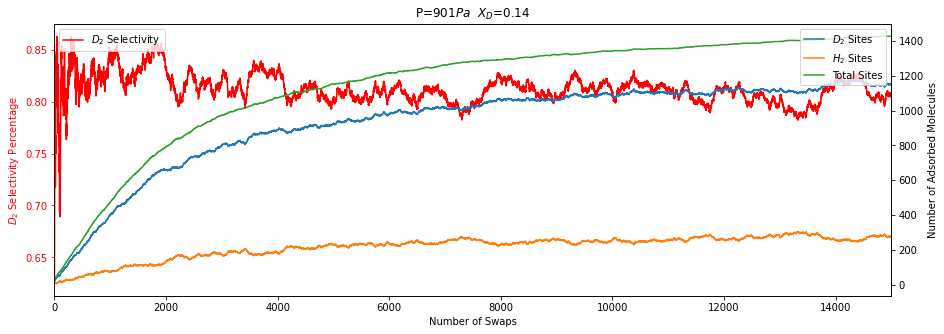

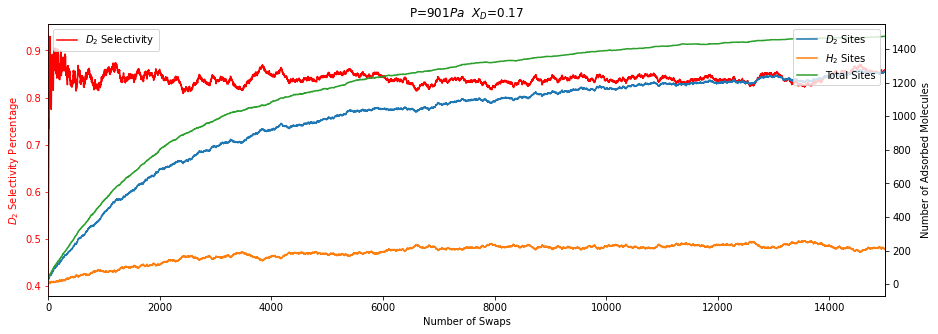

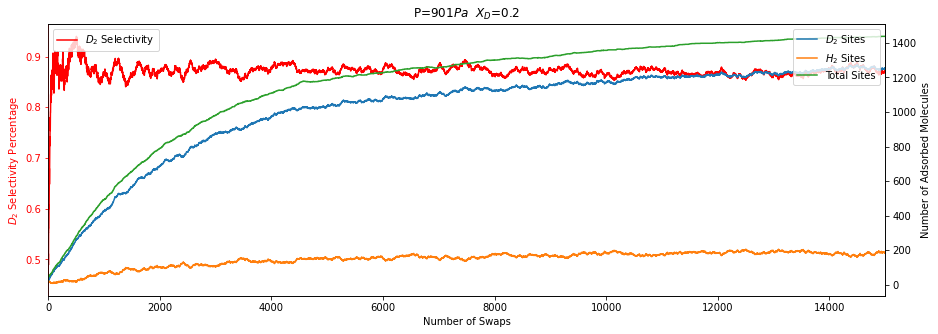

In [ ]:
for P1 in np.append(np.arange(1,100,20),np.arange(101,1000,100)):
  for x in np.arange(0.02,0.21,0.03):
    P1 = np.round(P1,2)
    x = np.round(x,3)
    H2lst = np.load('SelectivityData/H2_P{}_X{}.npy'.format(str(P1),str(x)))
    D2lst = np.load('SelectivityData/D2_P{}_X{}.npy'.format(str(P1),str(x)))
    fig, ax = plt.subplots(figsize =(15,5))
    axs = ax.twinx()
    ax.plot(D2lst/(D2lst+H2lst),label=r'$D_2$ Selectivity',c='red')

    axs.plot(D2lst,label=r'$D_2$ Sites')
    axs.plot(H2lst,label=r'$H_2$ Sites')
    axs.plot(H2lst+D2lst,label='Total Sites')
    ax.set_title('P={}$Pa$  $X_D$={}'.format(str(P1),str(x)))
    ax.legend(loc='upper left')
    axs.legend(loc='upper right')
    ax.autoscale(enable=True, axis='x', tight=True)

    ax.spines['left'].set_color('red')
    ax.yaxis.label.set_color('red')
    ax.tick_params(axis='y', colors='red')

    ax.set_xlabel('Number of Swaps')
    ax.set_ylabel('$D_2$ Selectivity Percentage')
    axs.set_ylabel('Number of Adsorbed Molecules')

    plt.show()

### Plot Selectivity VS Partial Pressure

In [ ]:
SelectivityDict = {}
for P1 in np.append(np.arange(1,100,20),np.arange(101,1000,100)):
  P1 = np.round(P1,2)
  SelectivityDict[P1] = {}
  for x in np.arange(0.02,0.21,0.03):
    x = np.round(x,3)
    H2lst = np.load('SelectivityData/H2_P{}_X{}.npy'.format(str(P1),str(x)))
    D2lst = np.load('SelectivityData/D2_P{}_X{}.npy'.format(str(P1),str(x)))
    SelectivityDict[P1][x] = {}
    SelectivityDict[P1][x]['H2'] = H2lst
    SelectivityDict[P1][x]['D2'] = D2lst

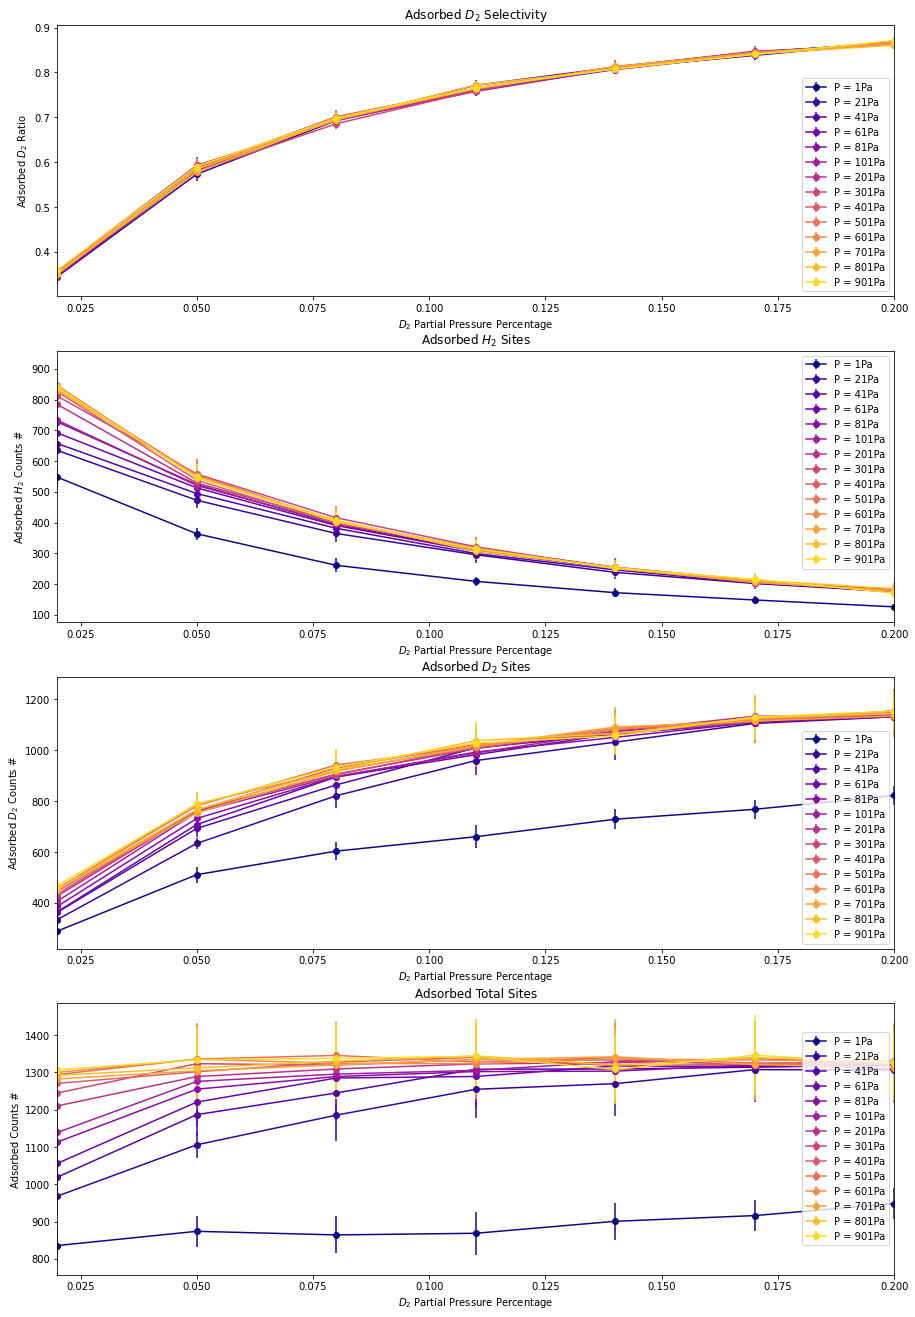

In [ ]:
my_cmap = plt.get_cmap("plasma")
size = np.append(np.arange(1,100,20),np.arange(101,1000,100)).size
rescale = lambda x:(x-1)/size
fig, ax = plt.subplots(4,figsize=(15,23))
n = 0
for key1 in SelectivityDict.keys():
  templstH = []
  templstHerror = []
  templstD = []
  templstDerror = []
  templstS = []
  templstSerror = []

  templstT = []
  templstTerror = []
  
  for key2 in SelectivityDict[key1].keys():
    templstH.append(np.mean(SelectivityDict[key1][key2]['H2'][4000:]))
    templstD.append(np.mean(SelectivityDict[key1][key2]['D2'][4000:]))
    templstHerror.append(np.std(SelectivityDict[key1][key2]['H2'][4000:]))
    templstDerror.append(np.std(SelectivityDict[key1][key2]['D2'][4000:]))

    Select_ = SelectivityDict[key1][key2]['D2'][4000:]/(SelectivityDict[key1][key2]['H2'][4000:]+SelectivityDict[key1][key2]['D2'][4000:])
    templstS.append(np.mean(Select_))
    templstSerror.append(np.std(Select_))

    Total_ = SelectivityDict[key1][key2]['D2'][4000:]+SelectivityDict[key1][key2]['H2'][4000:]
    templstT.append(np.mean(Total_))
    templstTerror.append(np.std(Total_))
  n = n+1
  ax[0].errorbar(np.round(np.arange(0.02,0.21,0.03),3),templstS,templstSerror,fmt='-o',label='P = {}Pa'.format(str(key1)),color=my_cmap(rescale(n)))
  ax[1].errorbar(np.round(np.arange(0.02,0.21,0.03),3),templstH,templstHerror,fmt='-o',label='P = {}Pa'.format(str(key1)),color=my_cmap(rescale(n)))
  ax[2].errorbar(np.round(np.arange(0.02,0.21,0.03),3),templstD,templstDerror,fmt='-o',label='P = {}Pa'.format(str(key1)),color=my_cmap(rescale(n)))
  ax[3].errorbar(np.round(np.arange(0.02,0.21,0.03),3),templstT,templstTerror,fmt='-o',label='P = {}Pa'.format(str(key1)),color=my_cmap(rescale(n)))

ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[3].legend(loc='right')

ax[0].autoscale(enable=True, axis='x', tight=True)
ax[1].autoscale(enable=True, axis='x', tight=True)
ax[2].autoscale(enable=True, axis='x', tight=True)
ax[3].autoscale(enable=True, axis='x', tight=True)

ax[0].set_title('Adsorbed $D_2$ Selectivity')
ax[0].set_xlabel('$D_2$ Partial Pressure Percentage')
ax[0].set_ylabel('Adsorbed $D_2$ Ratio')

ax[1].set_title('Adsorbed $H_2$ Sites')
ax[1].set_xlabel('$D_2$ Partial Pressure Percentage')
ax[1].set_ylabel('Adsorbed $H_2$ Counts #')

ax[2].set_title('Adsorbed $D_2$ Sites')
ax[2].set_xlabel('$D_2$ Partial Pressure Percentage')
ax[2].set_ylabel('Adsorbed $D_2$ Counts #')

ax[3].set_title('Adsorbed Total Sites')
ax[3].set_xlabel('$D_2$ Partial Pressure Percentage')
ax[3].set_ylabel('Adsorbed Counts #')

plt.show()
